In [434]:
import pinocchio
import numpy as np
import time 
import pymanopt 
from pymanopt import manifolds, optimizers, tools, core
from pymanopt.core.problem  import Problem
from pymanopt.tools.diagnostics import *
from utils import *
import networkx as nx
from scipy import optimize
from scipy.optimize import Bounds
import matplotlib.pyplot as plt

import tqdm

from scipy.sparse import csr_array

LOWER = "lower_limit"
UPPER = "upper_limit"
BOUNDED = "bounded"
BELOW = "below"
ABOVE = "above"
TYPE = "type"
OBSTACLE = "obstacle"
ROBOT = "robot"
END_EFFECTOR = "end_effector"
RADIUS = "radius"
DIST = "weight"
POS = "pos"
BASE = "base"
ROOT = None
ANCHOR = "anchor"
BASE_GRAPH = "base_graph"
UNDEFINED = None


deg2rad = np.pi/180.
rad2deg = 180./np.pi

scale = 1

%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [435]:
def forwardKinematics(model,data,q,scale=1):
    pinocchio.forwardKinematics(model,data,q)
    for idx, oMi in enumerate(data.oMi):
        oMi.translation = scale*oMi.translation


def compute_rotation_axis_from_model(model,data):
    axis = []
    q0 = pinocchio.neutral(model)
    for i in range(q0.shape[0]):
        q = np.zeros((q0.shape[0]))
        q[i] = np.pi/4
        pinocchio.forwardKinematics(model,data,q)
        R_ref = data.oMi[i+1].rotation
        
        if np.abs(np.sum(R_ref@np.array([1.,0,0.])) - 1) < 10**-4 or np.abs(np.sum(R_ref@np.array([1,0,0.])) + 1) < 10**-4:
            axis.append('x')
        elif np.abs(np.sum(R_ref@np.array([0,1,0.])) - 1) < 10**-4 or np.abs(np.sum(R_ref@np.array([0,1,0.])) + 1) < 10**-4:
            axis.append('y')
        elif np.abs(np.sum(R_ref@np.array([0,0,1.])) - 1) < 10**-4 or np.abs(np.sum(R_ref@np.array([0,0,1.])) + 1) < 10**-4:
            axis.append('z')
        else:
            print(2)
    return axis

def trans_axis(axis,axis_length):
    if axis=='x':
        return pinocchio.SE3(np.eye(3),np.array([axis_length,0.,0]))
    elif axis=='y':
        return pinocchio.SE3(np.eye(3),np.array([0,axis_length,0.]))
    elif axis=='z':
        return pinocchio.SE3(np.eye(3),np.array([0,0.,axis_length]))


In [436]:
def create_base_graph(model,data,axis_length,base_anchor=True):

    trans_z = [trans_axis(axis,axis_length) for axis in model_axis]
    #trans_z = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))

    q_init = pinocchio.neutral(model)
    
    pinocchio.forwardKinematics(model,data,q_init)
    
    robot_name = model.names[1]
    ROOT = robot_name

    base = nx.empty_graph()

    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 1:
            cur, aux_cur = (name, name+'_tilde')
            cur_pos, aux_cur_pos = (
                oMi.translation*scale,
                pinocchio.SE3.act(pinocchio.SE3(oMi.rotation,oMi.translation*scale),trans_z[idx-1]).translation,
            )

            #print(name,trans_z[idx-1].translation)
            
            dist = np.linalg.norm(cur_pos - aux_cur_pos)

            # Add nodes for joint and edge between them
            base.add_nodes_from(
                [(cur, {POS: cur_pos}), (aux_cur, {POS: aux_cur_pos})]
            )
            base.add_edge(
                cur, aux_cur, **{DIST: dist, LOWER: dist, UPPER: dist, BOUNDED: [], ANCHOR: False}
            )
            
            # If there exists a preceeding joint, connect it to new
            if idx != 0:
                pred, aux_pred = (model.names[idx-1], model.names[idx-1]+'_tilde')
                for u in [pred, aux_pred]:
                    for v in [cur, aux_cur]:
                        dist = np.linalg.norm(
                            base.nodes[u][POS] - base.nodes[v][POS]
                        )
                        base.add_edge(
                            u,
                            v,
                            **{DIST: dist, LOWER: dist, UPPER: dist, BOUNDED: [], ANCHOR: False},
                        )
        elif idx == 1:
            #print(name,oMi.translation)
            base = nx.DiGraph(
                [
                    (robot_name, "x"),
                    (robot_name, "y"),
                    (robot_name, robot_name+'_tilde'),
                    ("x", "y"),
                    ("y", robot_name+'_tilde'),
                    (robot_name+'_tilde' ,"x"),
                ]
            )
            base.add_nodes_from(
                [
                    ("x", {POS: np.array([axis_length, 0, 0]) + oMi.translation*scale, TYPE: [BASE]}),
                    ("y", {POS: np.array([0, -axis_length, 0]) + oMi.translation*scale, TYPE: [BASE]}),
                    (robot_name, {POS: oMi.translation*scale, TYPE: [ROBOT, BASE]}),
                    (robot_name+'_tilde', {POS: trans_z[idx-1].translation + oMi.translation*scale, TYPE: [ROBOT, BASE]}),
                ]
            )
            for u, v in base.edges():
                base[u][v][DIST] = np.linalg.norm(base.nodes[u][POS] - base.nodes[v][POS])
                base[u][v][LOWER] = base[u][v][DIST]
                base[u][v][UPPER] = base[u][v][DIST]
                base[u][v][ANCHOR] = base_anchor
                base[u][v][BOUNDED] = []

    # Set node type to robot
    nx.set_node_attributes(base, [ROBOT], TYPE)
    base.nodes[ROOT][TYPE] = [ROBOT, BASE]
    base.nodes[ROOT + '_tilde'][TYPE] = [ROBOT, BASE]


    return base


In [550]:

def norm(x):
    return x/max(np.linalg.norm(x),10**-9)

def goal_graph(model, data, G2, axis_length, position, direction = None, anchor = True):
    
    end_effector = [model.names[-1]]
    if direction is not None:
        end_effector.append(model.names[-1]+'_tilde')

    list_nodes_base = ['x','y',model.names[1],model.names[1]+'_tilde']

    for i, cur_end_effector in enumerate(end_effector):
        pos_end = position

        if direction is not None and i == 1:
            pos_end = pos_end + direction*axis_length
        
        G2.nodes[cur_end_effector][POS] = pos_end

        for cur_base in list_nodes_base:
            
            if not((i == 1) and (len(end_effector)==1)):
                dist = np.linalg.norm(pos_end-G2.nodes[cur_base][POS])

                G2.add_edge(
                            cur_base, cur_end_effector, **{DIST: dist, LOWER: dist, UPPER: dist, BOUNDED: [], ANCHOR: anchor}
                        )
    if direction is not None:
        dist = axis_length
        G2.add_edge(
                            model.names[-1],model.names[-1]+'_tilde', **{DIST: dist, LOWER: dist, UPPER: dist, BOUNDED: [], ANCHOR: anchor}
                        )
    
    if anchor:

        list_edges_anchor = []
        list_other_edges = []
        new_edge_order  = []
        A_anchor = []

        for key ,anch_ in nx.get_edge_attributes(G2,ANCHOR).items():

            if anch_:
                list_edges_anchor.append(key)
                A_anchor.append(norm(G2.nodes[key[1]][POS]- G2.nodes[key[0]][POS]))
                #print(key,' : ',norm(G.nodes[key[1]][POS]- G.nodes[key[0]][POS]))
            else:
                list_other_edges.append(key)
        new_edge_order = list_edges_anchor.copy() #.extend(list_other_edges)

        for e in list_other_edges:
            new_edge_order.append(e)

        A_anchor = np.array(A_anchor).transpose()
        
    else:

        list_edges_anchor = []
        list_other_edges = []
        A_anchor = []
        #list_other_edges = [e for e in G2.edges()]

        for key ,anch_ in nx.get_edge_attributes(G2,ANCHOR).items():

            if anch_:
                list_edges_anchor.append(key)
                A_anchor.append(norm(G2.nodes[key[1]][POS]- G2.nodes[key[0]][POS]))
                #print(key,' : ',norm(G.nodes[key[1]][POS]- G.nodes[key[0]][POS]))
            else:
                list_other_edges.append(key)

        new_edge_order = list_other_edges
        

    n = len(list_other_edges)
    n_anchor = len(list_edges_anchor)

    weight = nx.get_edge_attributes(G2, DIST)
    D = np.diag([weight[i] for i in new_edge_order])

    C = incidence_matrix_(G2,oriented=True, edgelist=new_edge_order).toarray()
    C = np.array(C)

    Y_init = np.zeros((3,n))

    for i, e in enumerate(list_other_edges):
        i = i 
        p1 = G2.nodes[e[0]][POS]
        p2 = G2.nodes[e[1]][POS]
        Y_init[:,i] = (p2-p1)/max(np.linalg.norm(p2-p1),10**-9)

    Y_init = [A_anchor,Y_init]
    return G2, list_edges_anchor, list_edges_anchor, new_edge_order, n,n_anchor, A_anchor, D,C, Y_init



In [625]:
alpha_elu = 10**-5
elu = lambda x: alpha_elu*(np.exp(x/alpha_elu*(x<0))-1)*(x<0) +  x*(x>=0)
d_elu = lambda x: np.exp(x/alpha_elu*(x<0))*(x<0) + (x>=0)
dd_elu = lambda x: 1/alpha_elu*np.exp(x/alpha_elu*(x<0))*(x<0)

def simple_IK(d ,C , C_joints_limit ,D ,D_joints ,n_below, n_above, Anchor_ ,M ,max_iter,ind=None ,W=None ,Y_init=None ,
                use_rand=False, min_grad_norm = 10**-10,verbosity = 2,lambda_cons=1, constraints=True):
    if  W is None:
        W = np.eye(D.shape[0])

    if len(Anchor_)>0:
        #print('ANCHOR')
        n_anchor = Anchor_.shape[1]
        Anchor = np.zeros((d,n_anchor))
        Anchor[:3,:] = Anchor_

        if constraints:
            M = manifolds.Product([manifolds.ConstantFactory(Anchor),
                    manifolds.Oblique(d,D.shape[1]-Anchor.shape[1]),
                    manifolds.ComplementBall(d, n_below, D_joints[:n_below], 10**-8)])
        else:
            M = manifolds.Product([manifolds.ConstantFactory(Anchor),
                    manifolds.Oblique(d,D.shape[1]-Anchor.shape[1])])
                
    else:
         n_anchor = 0
         if  constraints:
            M = manifolds.Product([manifolds.Oblique(d,D.shape[1]),
                    manifolds.ComplementBall(d, n_below, D_joints[:n_below], 10**-8)])
         else:
            M = manifolds.Product([manifolds.Oblique(d,D.shape[1])])

    Q2_ = -D@(W@C.transpose()@np.linalg.pinv(C@W@C.transpose()))@C@W@D
    Q1_ = D@W@D

    Q_below = C_joints_limit[:n_below,:D.shape[0]]
    Q_above = C_joints_limit[n_below:,:D.shape[0]]
    #print('C_joints',C_joints_limit.shape)

    if constraints:
        Q2 = lambda_cons**2*C_joints_limit.transpose()@C_joints_limit #np.zeros((C_joints_limit.shape[1],C_joints_limit.shape[1]))
        Q1 = np.zeros((C_joints_limit.shape[1],C_joints_limit.shape[1]))
        Q2[:Q2_.shape[0],:Q2_.shape[1]] = Q2_ + Q2[:Q2_.shape[0],:Q2_.shape[1]]
        Q1[:Q1_.shape[0],:Q1_.shape[1]] = Q1_
    else:
        Q2 = Q2_
        Q1 = Q1_

    D_below = D_joints[:n_below]**2
    D_above = D_joints[n_below:]**2
    #print(Q_below.shape)

    Y = M.random_point()
    ind = [0]
    ind.extend([y.shape[1] for y in Y])
    ind = np.array(ind)
    ind = np.cumsum(ind)
    n = len(Y)

    @pymanopt.function.numpy(M)
    def cost(*Y):
        
        Y = np.concatenate(Y,axis=1)
       # print(np.trace(C_joints_limit@Y.transpose()@Y@C_joints_limit.transpose()),np.trace(Q1_ + Q2_@Y[:D.shape[0],:D.shape[0]].transpose()@Y[:D.shape[0],:D.shape[0]]),np.trace(Q1 + Q2@Y.transpose()@Y))
        #constr_below = - (np.linalg.norm(Q_below@Y.transpose(),axis=1)**2 - D_below)
        #constr_above = (np.linalg.norm(Q_above@Y.transpose(),axis=1)**2 - D_above)

        #constr = lambda_cons*(np.linalg.norm(np.maximum(constr_below, 0))**2 + np.linalg.norm(np.maximum(constr_above, 0))**2) 
        #constr = lambda_cons*(np.sum(np.maximum(constr_below, 0)) + np.sum(np.maximum(constr_above, 0))) 
        #constr = lambda_cons*(np.sum(elu(constr_below)) + np.sum(np.maximum(constr_above, 0))) 

        #print(constr,constr_below)
        return np.trace(Q1 + Q2@Y.transpose()@Y) #+ constr
    #print('init cost: ', cost(Y_init))
    QQ_below = np.array([q[:,np.newaxis]@q[:,np.newaxis].transpose() for q in Q_below])
    zip_below = zip(D_below,Q_below,QQ_below)
    zip_above = zip(D_above,Q_above)
    @pymanopt.function.numpy(M)
    def euclidean_gradient(*Y):
        Y = np.concatenate(Y,axis=1)
        grad = 2*Q2@Y.transpose()

        #grad_below = - sum([4*max((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*qq@Y.transpose() for d,q,qq in zip_below])
        #grad_below = - sum([2*((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0))*qq@Y.transpose() for d,q,qq in zip_below])
        # grad_below = - sum([2*((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0))*d_elu(d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2)*qq@Y.transpose() for d,q,qq in zip_below])

        #if len(D_above)>0:
            #grad_above= sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose() for d,q in zip_above])
        #else:
            # grad_above = 0
        #print('grad',np.linalg.norm(grad_above))
        #grad = grad + lambda_cons*(grad_below + grad_above)
        return [grad.transpose()[:,start:end] for start, end in zip(ind[:-1],ind[1:])]
                            
    @pymanopt.function.numpy(M)
    def euclidean_hessian(*U):
        
        Y = np.concatenate(U[:n],axis=1)
        U = np.concatenate(U[n:],axis=1)

        #hess_below = sum([-4*max((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*qq@U.transpose() + 8*(qq@Y.transpose())@Y@(qq)@U.transpose()*(d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0) for d,q,qq in zip(D_below,Q_below,QQ_below)])
        
        #hess_below = sum([2*((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0))*qq@U.transpose() for d,q,qq in zip(D_below,Q_below,QQ_below)])
        #hess_below = - sum([2*((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0))*dd_elu(d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2)*qq@Y.transpose() for d,q,qq in zip_below])

        #if len(D_above)>0:
        #    hess_above = sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@U.transpose() + 8*(q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose())@Y@(q[:,np.newaxis]@q[:,np.newaxis].transpose())@U.transpose()*(-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0) for d,q in zip(D_above,Q_above)])
        #else:
            #   hess_above = 0

        #hess_above= sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@U.transpose() + 8*((q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose())@U)@(q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose()) for d,q in zip(D_above,Q_above)])

        #hess =  lambda_cons*(hess_above + hess_below)
        
        hess = (2*Q2 )@U.transpose() #+ hess

        return [hess.transpose()[:,start:end] for start, end in zip(ind[:-1],ind[1:])]
    


    problem = Problem(manifold=M, 
                        cost=cost,
                        euclidean_gradient=euclidean_gradient, 
                        euclidean_hessian=euclidean_hessian,
                        )
    #check_gradient(problem)
    optimizer = optimizers.TrustRegions(max_iterations=max_iter,use_rand=use_rand,min_gradient_norm=min_grad_norm,verbosity=verbosity)
    

    if  Y_init is None:
        Y_init_ = M.random_point()
    elif n_anchor > 1:
        if Y_init[1].shape[0] == d:
            Y_init_ = Y_init
            
        elif Y_init[1].shape[0] < d:
            Y_init_ = np.zeros((d,Y[1].shape[1]))
            Y_init_[:Y_init[1].shape[0],:] = Y_init[1]
            Y_init_ = [Anchor, Y_init_]
            #Y_init_ = [Y_init_[1]]
            #Y_init_.append((C_joints_limit[:,:D.shape[0]]@np.concatenate(Y_init_,axis=1).transpose()).transpose())
            if constraints:
                Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@np.concatenate(Y_init_,axis=1).transpose()).transpose())
            #Y_init_.append((C_joints_limit[n_below:,:D.shape[0]]@np.concatenate(Y_init_[:2],axis=1).transpose()).transpose())
            #Y_init_[2] = np.array([norm(y) for y in Y_init_[2].transpose()])
        else:
            U,S,V = np.linalg.svd(Y_init[1],full_matrices=False) 
            
            Y_init_ = [Anchor, U[:d,:d]@np.diag(S)[:d,:]@V/np.maximum(np.linalg.norm(U[:d,:d]@np.diag(S)[:d,:]@V,axis=0),10**-9)]
            #Y_init_ = [Y_init_]
            
            #Y_init_[2] = (C_joints_limit[:,:D.shape[0]]@np.concatenate(Y_init_[:2],axis=1).transpose()).transpose()

            if constraints:
                Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@np.concatenate(Y_init_,axis=1).transpose()).transpose())
            #Y_init_.append((C_joints_limit[:,:D.shape[0]]@np.concatenate(Y_init_[:2],axis=1).transpose()).transpose())
            #Y_init_[2] = np.array([norm(y) for y in Y_init_[2].transpose()])
    else:
        if Y_init[1].shape[0] == d:
            Y_init_ = Y_init
            
        elif Y_init[1].shape[0] < d:
            Y_init_ = np.zeros((d,Y[0].shape[1]))
            #print(Y_init[1].shape[0],Y_init[1].shape)
            Y_init_[:Y_init[1].shape[0],:] = Y_init[1]
            Y_init_ = [Y_init_]
            #Y_init_ = [Y_init_[1]]
            #Y_init_.append((C_joints_limit[:,:D.shape[0]]@np.concatenate(Y_init_,axis=1).transpose()).transpose())
            if constraints:
                Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@Y_init_[0].transpose()).transpose())
            #Y_init_.append((C_joints_limit[n_below:,:D.shape[0]]@np.concatenate(Y_init_[:2],axis=1).transpose()).transpose())
            #Y_init_[2] = np.array([norm(y) for y in Y_init_[2].transpose()])
        else:
            U,S,V = np.linalg.svd(Y_init[0],full_matrices=False) 
            
            Y_init_ = [U[:d,:d]@np.diag(S)[:d,:]@V/np.maximum(np.linalg.norm(U[:d,:d]@np.diag(S)[:d,:]@V,axis=0),10**-9)]
            #Y_init_ = [Y_init_]
            
            #Y_init_[2] = (C_joints_limit[:,:D.shape[0]]@np.concatenate(Y_init_[:2],axis=1).transpose()).transpose()

            if constraints:
                Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@Y_init_[0].transpose()).transpose())
   # Y_init_ = np.zeros((d,Y[0].shape[1]))
    #print(Y_init[0].shape,Y_init_[:Y_init[0].shape[0],:].shape)
   # Y_init_[:Y_init[0].shape[0],:] = Y_init[0]
   # Y_init_ = [Y_init_]
    #Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@Y_init_[0].transpose()).transpose())
    #[print(y.shape) for y in Y_init_]
    #[print(type(y)) for y in Y_init_]
    #print('init cost: ', cost(Y_init_))
    Y_star = optimizer.run(problem,initial_point=Y_init_).point

    return Y_star, Q2+Q1


In [439]:
W = np.diag(1./np.diag(D)**2)
M=None
lambda_cons = 10**0
n_below = len(list_edges_below)
n_above = len(list_edges_above)
print(position,direction)

Y_D4,Q2 = simple_IK(4,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=400,ind=None,W=W,Y_init=Y_init_,use_rand=False,lambda_cons=lambda_cons,min_grad_norm=10**-8)
Y_D3,Q2 = simple_IK(3,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=3000,ind=None,W=W,Y_init=Y_D4,use_rand=False,lambda_cons=lambda_cons)


[-0.17048658  0.24730285  0.67438484] [-0.99353113 -0.11191355 -0.01926794]
Optimizing...
                                            f: +2.495343e+00   |grad|: 1.869803e+00
acc TR+   k:     1     num_inner:     1     f: +9.145297e-01   |grad|: 8.318052e-01   exceeded trust region
REJ TR-   k:     2     num_inner:     4     f: +9.145297e-01   |grad|: 8.318052e-01   negative curvature
acc TR+   k:     3     num_inner:     2     f: +5.563426e-01   |grad|: 4.712326e-01   exceeded trust region
acc       k:     4     num_inner:     2     f: +4.557804e-01   |grad|: 7.745662e-01   exceeded trust region
acc       k:     5     num_inner:     4     f: +2.209706e-01   |grad|: 5.695998e-01   exceeded trust region
REJ TR-   k:     6     num_inner:     5     f: +2.209706e-01   |grad|: 5.695998e-01   exceeded trust region
acc TR+   k:     7     num_inner:     2     f: +9.534927e-02   |grad|: 1.574283e-01   exceeded trust region
acc       k:     8     num_inner:     2     f: +5.720326e-02   |grad|: 3.

In [440]:
print(position,direction)
np.linalg.svd(Y_D4[0],full_matrices=False)

[-0.17048658  0.24730285  0.67438484] [-0.99353113 -0.11191355 -0.01926794]


SVDResult(U=array([[-0.51864097, -0.76618879,  0.3794289 ,  0.        ],
       [ 0.41156099, -0.61270731, -0.67469053,  0.        ],
       [ 0.74941917, -0.19376402,  0.63310853,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), S=array([3.21379973, 1.84992762, 1.1177026 , 0.        ]), Vh=array([[-0.16137937, -0.12806056,  0.23318789,  0.29923126,  0.30976784,
         0.02355996,  0.31046671,  0.30224147,  0.25544123,  0.2921387 ,
         0.30765305, -0.27900118,  0.30526143,  0.30511223,  0.14151066],
       [-0.41417231,  0.3312061 , -0.10474141, -0.10991443,  0.03099099,
         0.52706212,  0.02017685,  0.12751545, -0.30826144, -0.18549033,
        -0.05717334, -0.21880069, -0.10381324,  0.07692801,  0.45057768],
       [ 0.33947214,  0.60364047,  0.56643738,  0.16460262,  0.0671292 ,
         0.18679522,  0.04938022, -0.0260157 , -0.02630656, -0.02475604,
        -0.09475286, -0.16048866, -0.0229964 , -0.12080252, -0.28063467],
       [ 0.03832651,

In [441]:
def direction_to_position(Y,C,D,data):
    X = np.linalg.pinv(C@C.transpose())@C@D@Y.transpose()
    
    X = X - X[0,:] + data.oMi[1].translation*scale

    v = X[1,:] - X[0,:]
    R = rotation_matrix_from_vectors(v/np.linalg.norm(v),e1/np.linalg.norm(e1))
    X = (X - X[0,:])@R.transpose() + X[0,:]

    v = X[2,:] - X[0,:]
    R = rotation_matrix_from_vectors(v/np.linalg.norm(v),-e2/np.linalg.norm(e2))
    X = (X - X[0,:])@R.transpose() + X[0,:]
    flip = 1

    if X[3,2]<axis_length:
        flip = -1
    v = X[2,:] - X[0,:]
    R = np.diag((1,1,flip))
    X = (X - X[0,:])@R.transpose() + X[0,:]

    v = Y[:,0]
    R1 = rotation_matrix_from_vectors(v/np.linalg.norm(v),e1/np.linalg.norm(e1))
    R2 = rotation_matrix_from_vectors(v/np.linalg.norm(v),e1/np.linalg.norm(e1))
    R_ = np.diag((1,-1,1))@np.linalg.inv(Y[:3,:3])
    return X, R_@Y

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix
new_edge_order

[('shoulder_pan_joint', 'x'),
 ('shoulder_pan_joint', 'y'),
 ('shoulder_pan_joint', 'shoulder_pan_joint_tilde'),
 ('shoulder_pan_joint', 'wrist_3_joint'),
 ('shoulder_pan_joint', 'wrist_3_joint_tilde'),
 ('x', 'y'),
 ('x', 'wrist_3_joint'),
 ('x', 'wrist_3_joint_tilde'),
 ('y', 'shoulder_pan_joint_tilde'),
 ('y', 'wrist_3_joint'),
 ('y', 'wrist_3_joint_tilde'),
 ('shoulder_pan_joint_tilde', 'x'),
 ('shoulder_pan_joint_tilde', 'wrist_3_joint'),
 ('shoulder_pan_joint_tilde', 'wrist_3_joint_tilde'),
 ('wrist_3_joint', 'wrist_3_joint_tilde'),
 ('shoulder_pan_joint', 'shoulder_lift_joint'),
 ('shoulder_pan_joint', 'shoulder_lift_joint_tilde'),
 ('shoulder_pan_joint_tilde', 'shoulder_lift_joint'),
 ('shoulder_pan_joint_tilde', 'shoulder_lift_joint_tilde'),
 ('shoulder_lift_joint', 'shoulder_lift_joint_tilde'),
 ('shoulder_lift_joint', 'elbow_joint'),
 ('shoulder_lift_joint', 'elbow_joint_tilde'),
 ('shoulder_lift_joint_tilde', 'elbow_joint'),
 ('shoulder_lift_joint_tilde', 'elbow_joint_tilde

In [442]:
def skew(x):
    """
    Creates a skew symmetric matrix from vector x
    """
    X = np.array([[0, -x[2], x[1]], [x[2], 0, -x[0]], [-x[1], x[0], 0]])
    return X


def joint_variables_(model,data, G, T_final, axis_length):
    """
    Finds the set of decision variables corresponding to the
    graph realization G.

    :param G: networkx.DiGraph with known vertex positions
    :param T_final: poses of end-effectors in case two final frames aligned along z
    :returns: Dictionary of joint angles
    :rtype: Dict[str, float]
    """
    tol = 1e-10
    
    T = {}
    T[model.names[1]] = data.oMi[1] #G.nodes[model.names[1]][POS]

    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    T_zero = {name: oMi for name, oMi in zip(model.names, data.oMi)}

    #trans_z = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))
    trans_z = [trans_axis(axis,axis_length) for axis in model_axis]
    #trans_z = [pinocchio.SE3(np.eye(3),np.array([0,0,axis_length])) for axis in model_axis]
    
    # resolve scale
    x_hat = G.nodes["x"][POS] - G.nodes[model.names[1]][POS]
    y_hat = G.nodes["y"][POS] - G.nodes[model.names[1]][POS]
    z_hat = G.nodes[model.names[1]+'_tilde'][POS] - G.nodes[model.names[1]][POS]

    # resolve rotation and translation
    x = norm(x_hat)
    y = norm(y_hat)
    z = norm(z_hat)
    R = np.vstack((x, -y, z)).T
    B = pinocchio.SE3(R, np.zeros((3,))) #G.nodes[ROOT][POS])

    #omega_z = skew(np.array([0,0,1]))
    omega_z = [skew(trans_axis(axis,1).translation) for axis in model_axis]
    #omega_z = [skew(np.array([0,0,1])) for axis in model_axis]
    theta = {}
    
    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 1:
            cur, aux_cur = (name, name+'_tilde')
            pred, aux_pred = (model.names[idx-1], model.names[idx-1]+'_tilde')

            T_prev = T[pred]
            
            T_prev_0 = T_zero[pred] # previous p xf at 0
            T_0 = T_zero[cur] # cur p xf at 0
            T_0_q = pinocchio.SE3.act(T_zero[cur],trans_z[idx-1]) # cur q xf at 0
            T_rel = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0) # relative xf
            ps_0 = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0).translation # relative xf
            qs_0 = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0_q).translation # rel q xf
            
            # predicted p and q expressed in previous frame
            p = pinocchio.SE3.act(pinocchio.SE3.inverse(B),G.nodes[cur][POS])
            qnorm = G.nodes[cur][POS] + (
                G.nodes[aux_cur][POS] - G.nodes[cur][POS]
            ) / np.linalg.norm(G.nodes[aux_cur][POS] - G.nodes[cur][POS])
            q = pinocchio.SE3.act(pinocchio.SE3.inverse(B),qnorm)
            #print(T_prev)
            ps = pinocchio.SE3.inverse(T_prev).rotation.dot(p - T_prev.translation)  # in prev. joint frame
            qs = pinocchio.SE3.inverse(T_prev).rotation.dot(q - T_prev.translation)  # in prev. joint frame
            rot = rot_axis(model_axis[idx-2])
            #theta[pred] = np.arctan2(-ps_0.dot(omega_z[idx-2]).dot(ps), ps_0.dot(omega_z[idx-2].dot(omega_z[idx-2].T)).dot(ps))
            theta[pred] = np.arctan2(-qs_0.dot(omega_z[idx-2]).dot(qs), qs_0.dot(omega_z[idx-2].dot(omega_z[idx-2].T)).dot(qs))
            
            #rot_axis_z = pinocchio.SE3(Rot_z(theta[cur]),np.zeros((3,)))
            rot_axis_z = pinocchio.SE3(rot(theta[pred]),np.zeros((3,)))
            T[cur] = pinocchio.SE3.act(pinocchio.SE3.act(T_prev,rot_axis_z),T_rel)
            #print(pred,cur,idx,trans_z[idx-2].translation,theta[pred]*rad2deg,ps,ps_0)
    # if the rotation axis of final joint is aligned with ee frame z axis,
    # get angle from EE pose if available
    #if ((T_final is not None) and (la.norm(cross(T_rel.trans, np.asarray([0, 0, 1]))) < tol)):
     #   T_th = (T[cur]).inv().dot(T_final[ee]).as_matrix()
     #   theta[ee] = wraptopi(theta[ee] +  arctan2(T_th[1, 0], T_th[0, 0]))

    return theta





In [443]:
def root_angle_limits(G,model,data,axis_length):
    upper_limits = np.minimum(-model.lowerPositionLimit,model.upperPositionLimit)
    limited_joints = [] 
    i = 2
    T1 = data.oMi[1]
    base_names = ["x", "y"]
    names = [model.names[i],model.names[i]+'_tilde']
    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    #T_axis = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))
    T_axis = [trans_axis(axis,axis_length) for axis in model_axis]

    for base_node in base_names:
        for node in names:
            T0 = pinocchio.SE3.Identity()
            T0.translation = G.nodes[base_node][POS]

            if node == model.names[i]:
                T2 = data.oMi[i]
            else:
                T2 = pinocchio.SE3.act(data.oMi[i],T_axis[i])

            N = T1.rotation[0:3, 2]
            C = T1.translation + (N.dot(T2.translation - T1.translation)) * N
            r = np.linalg.norm(T2.translation - C)
            P = T0.translation
            d_max, d_min = max_min_distance_revolute(r, P, C, N)
            d = np.linalg.norm(T2.translation - T0.translation)

            if d_max == d_min:
                limit = False
            elif d == d_max:
                limit = BELOW
            elif d == d_min:
                limit = ABOVE
            else:
                limit = None

            if limit:
                T_rel = pinocchio.SE3.act(pinocchio.SE3.inverse(T1),data.oMi[i])
                if node != model.names[i]:
                    T_rel = pinocchio.SE3.act(T_rel,T_axis[i])

                d_limit = np.linalg.norm(
                    pinocchio.SE3.act(pinocchio.SE3.act(T1,pinocchio.SE3(Rot_z(upper_limits[0]),np.zeros((3,)))),T_rel).translation
                    - T0.translation
                )

                q0 = np.zeros((upper_limits.shape[0]))
                q0[0] = upper_limits[0]
                
                pinocchio.framesForwardKinematics(model,data,q0)

                if '_tilde' not in node:
                    d_limit = np.linalg.norm(data.oMi[1].translation-T0.translation)
                if '_tilde' in node:
                    d_limit = np.linalg.norm(pinocchio.SE3.act(data.oMi[1],T_axis[i]).translation-T0.translation)

                if limit == ABOVE:
                    d_max = d_limit
                else:
                    d_min = d_limit
                limited_joints += [model.names[i]]  # joint at p0 is limited
            
            G.add_edge(base_node, node)
            if d_max == d_min:
                G[base_node][node][DIST] = d_max
            G[base_node][node][BOUNDED] = [limit]
            G[base_node][node][UPPER] = d_max
            G[base_node][node][LOWER] = d_min

            

    return G

In [444]:
def set_limits(G,model,data,axis_length):
    """
    Sets known bounds on the distances between joints.
    This is induced by link length and joint limits.
    """
    #T_axis = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))
    T_axis = [trans_axis(axis,axis_length) for axis in model_axis]
    upper_limits = np.minimum(-model.lowerPositionLimit,model.upperPositionLimit)#-5*deg2rad

    limited_joints = []  # joint limits that can be enforced

    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    T_zero = {name: oMi for name, oMi in zip(model.names, data.oMi)}
    
    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 2:
            cur, prev = name, model.names[idx - 2]
            names = [
                (prev, name),
                (prev,name+'_tilde'),
                (prev+'_tilde', name),
                (prev+'_tilde', name+'_tilde'),
            ]


            for ids in names:
                q0 = np.zeros((upper_limits.shape[0]))
                q0[idx-2] = upper_limits[idx-2]
                #print(prev,cur,idx)
                pinocchio.framesForwardKinematics(model,data,q0)
                if '_tilde' not in ids[0] and '_tilde' not in ids[1]:
                    TT1 = pinocchio.SE3.Identity()
                    TT2 = pinocchio.SE3.Identity()
                elif '_tilde' in ids[1] and '_tilde' not in ids[0]:
                    TT1 = pinocchio.SE3.Identity()
                    TT2 = T_axis[idx-1]
                elif '_tilde' not in ids[1] and '_tilde' in ids[0]:
                    TT1 = T_axis[idx-3]
                    TT2 = pinocchio.SE3.Identity()
                else:
                    TT1 = T_axis[idx-3]
                    TT2 = T_axis[idx-1]

                q0 = np.zeros((upper_limits.shape[0]))
                q0[idx-2] = upper_limits[idx-2]
                pinocchio.framesForwardKinematics(model,data,q0)
                d_limit = np.linalg.norm(pinocchio.SE3.act(data.oMi[idx-2],TT1).translation - pinocchio.SE3.act(data.oMi[idx],TT2).translation)
                
                list_dist = []
                
                for theta in np.linspace(0,upper_limits[idx-2],101):
                    q0 = np.zeros((upper_limits.shape[0]))
                    q0[idx-2] = theta
                    pinocchio.framesForwardKinematics(model,data,q0)
                    list_dist.append(np.linalg.norm(pinocchio.SE3.act(data.oMi[idx-2],TT1).translation - pinocchio.SE3.act(data.oMi[idx],TT2).translation))
                
                list_dist = np.array(list_dist)
                diff_dist = list_dist[:-1] - list_dist[1:]
                
                d_max = max(list_dist)
                d_min = min(list_dist)
                if np.max(np.abs(diff_dist))<10**-7:
                    limit = False
                    d_max = d_limit
                    d_min = d_limit
                elif sum((diff_dist > 0)) == 100:
                    limit = BELOW
                elif sum((diff_dist < 0)) == 100:
                    limit = ABOVE
                else:
                    limit=False
                    print('#############################################')


                limited_joints += [cur]

                G.add_edge(ids[0], ids[1])
                if d_max == d_min:
                    G[ids[0]][ids[1]][DIST] = d_max
                G[ids[0]][ids[1]][BOUNDED] = [limit]
                G[ids[0]][ids[1]][UPPER] = d_max
                G[ids[0]][ids[1]][LOWER] = d_min

                if limit:
                    break
    return G, limited_joints

In [445]:
def constraints_graph(model, data, G, D, new_edge_order, axis_length):
    D_tilde = {name: [val, ind] for ind, (name, val) in enumerate(zip(new_edge_order,D))}

    list_edges_below = []
    list_edges_above = []

    D_below = []
    D_above = []

    path = {}

    for n1 in G.nodes():
        for n2 in G.nodes():

            path[(n1,n2)] = []

            if n1 != n2 and ((n1,n2) not in new_edge_order):
                for p in nx.all_simple_edge_paths(G, n1, n2, 2):
                    if len(p)>1:
                        path[(n1,n2)].append(p)

    G = root_angle_limits(G,model,data,axis_length)
    G, lim_joints = set_limits(G,model,data,axis_length)

    for edge, val in nx.get_edge_attributes(G,BOUNDED).items():

        if BELOW in val:
            D_below.append(G[edge[0]][edge[1]][LOWER])
            list_edges_below.append(edge)
        if ABOVE in val and False:
            D_above.append(G[edge[0]][edge[1]][UPPER])
            list_edges_above.append(edge)

    list_edges_joints_limit = list_edges_below.copy()
    list_edges_joints_limit.extend(list_edges_above)
    
    D_joints_limit = D_below.copy()
    D_joints_limit.extend(D_above)
    
    C_joints_limit = np.zeros((len(list_edges_joints_limit),len(list_edges_joints_limit)+len(new_edge_order)))
    #print(D_tilde)
    for idx, e in enumerate(list_edges_joints_limit):
        p = path[e][0]
        
        C_joints_limit[idx,D_tilde[p[0]][1]] = D_tilde[p[0]][0]
        C_joints_limit[idx,D_tilde[p[1]][1]] = D_tilde[p[1]][0]

        C_joints_limit[idx,len(new_edge_order)+idx] = -1
    
    return G, D_joints_limit, list_edges_joints_limit, C_joints_limit, list_edges_below, list_edges_above


In [446]:
def joint_variables(model,data, G, T_final, axis_length):
    """
    Finds the set of decision variables corresponding to the
    graph realization G.

    :param G: networkx.DiGraph with known vertex positions
    :param T_final: poses of end-effectors in case two final frames aligned along z
    :returns: Dictionary of joint angles
    :rtype: Dict[str, float]
    """
    tol = 1e-10
    
    T = {}
    T[model.names[1]] = data.oMi[1] #G.nodes[model.names[1]][POS]

    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    T_zero = {name: oMi for name, oMi in zip(model.names, data.oMi)}

    #trans_z = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))
    trans_z = [trans_axis(axis,axis_length) for axis in model_axis]
    #trans_z = [pinocchio.SE3(np.eye(3),np.array([0,0,axis_length])) for axis in model_axis]
    
    # resolve scale
    x_hat = G.nodes["x"][POS] - G.nodes[model.names[1]][POS]
    y_hat = G.nodes["y"][POS] - G.nodes[model.names[1]][POS]
    z_hat = G.nodes[model.names[1]+'_tilde'][POS] - G.nodes[model.names[1]][POS]

    # resolve rotation and translation
    x = norm(x_hat)
    y = norm(y_hat)
    z = norm(z_hat)
    R = np.vstack((x, -y, z)).T
    B = pinocchio.SE3(R, np.zeros((3,))) #G.nodes[ROOT][POS])

    #omega_z = skew(np.array([0,0,1]))
    omega_z = [skew(trans_axis(axis,1).translation) for axis in model_axis]
    #omega_z = [skew(np.array([0,0,1])) for axis in model_axis]
    theta = {}
    
    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 1:
            cur, aux_cur = (name, name+'_tilde')
            pred, aux_pred = (model.names[idx-1], model.names[idx-1]+'_tilde')

            T_prev = T[pred]
            
            T_prev_0 = T_zero[pred] # previous p xf at 0
            T_0 = T_zero[cur] # cur p xf at 0
            T_0_q = pinocchio.SE3.act(T_zero[cur],trans_z[idx-1]) # cur q xf at 0
            T_rel = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0) # relative xf
            ps_0 = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0).translation # relative xf
            qs_0 = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0_q).translation # rel q xf
            
            # predicted p and q expressed in previous frame
            p = pinocchio.SE3.act(pinocchio.SE3.inverse(B),G.nodes[cur][POS])
            qnorm = G.nodes[cur][POS] + (
                G.nodes[aux_cur][POS] - G.nodes[cur][POS]
            ) / np.linalg.norm(G.nodes[aux_cur][POS] - G.nodes[cur][POS])
            q = pinocchio.SE3.act(pinocchio.SE3.inverse(B),qnorm)
            #print(T_prev)
            ps = pinocchio.SE3.inverse(T_prev).rotation.dot(p - T_prev.translation)  # in prev. joint frame
            qs = pinocchio.SE3.inverse(T_prev).rotation.dot(q - T_prev.translation)  # in prev. joint frame
            rot = rot_axis(model_axis[idx-2])
            
            theta[pred] = np.arctan2(-ps_0.dot(omega_z[idx-2]).dot(ps), ps_0.dot(omega_z[idx-2].dot(omega_z[idx-2].T)).dot(ps))
            #theta[pred] = np.arctan2(-qs_0.dot(omega_z[idx-2]).dot(qs), qs_0.dot(omega_z[idx-2].dot(omega_z[idx-2].T)).dot(qs))
            
            #print(qs.dot(skew(qs_0)).dot(qs), qs_0.dot(qs))
            #rot_axis_z = pinocchio.SE3(Rot_z(theta[cur]),np.zeros((3,)))
            rot_axis_z = pinocchio.SE3(rot(theta[pred]),np.zeros((3,)))
            T[cur] = pinocchio.SE3.act(pinocchio.SE3.act(T_prev,rot_axis_z),T_rel)
            print(idx, ps_0, ps, )
            #print(pred,cur,idx,trans_z[idx-2].translation,theta[pred]*rad2deg,ps,ps_0)
    # if the rotation axis of final joint is aligned with ee frame z axis,
    # get angle from EE pose if available
    #if ((T_final is not None) and (la.norm(cross(T_rel.trans, np.asarray([0, 0, 1]))) < tol)):
     #   T_th = (T[cur]).inv().dot(T_final[ee]).as_matrix()
     #   theta[ee] = wraptopi(theta[ee] +  arctan2(T_th[1, 0], T_th[0, 0]))

    return theta

def trans_axis(axis,axis_length):
    if axis=='x':
        return pinocchio.SE3(np.eye(3),np.array([axis_length,0.,0]))
    elif axis=='y':
        return pinocchio.SE3(np.eye(3),np.array([0,axis_length,0.]))
    elif axis=='z':
        return pinocchio.SE3(np.eye(3),np.array([0,0.,axis_length]))
    

def joint_variables(model,data, Y, new_edge_order, T_final, axis_length):   
    
    T = {}
    T[model.names[1]] = data.oMi[1] 

    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    T_zero = {name: oMi for name, oMi in zip(model.names, data.oMi)}

    trans_z = [trans_axis(axis,axis_length) for axis in model_axis]
    omega_z = [skew(trans_axis(axis,1).translation) for axis in model_axis]
    
    theta = {}
    
    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 1:
            cur, aux_cur = (name, name+'_tilde')
            pred, aux_pred = (model.names[idx-1], model.names[idx-1]+'_tilde')

            T_prev = T[pred]
            
            T_prev_0 = T_zero[pred] # previous p xf at 0
            T_0 = T_zero[cur] # cur p xf at 0
            T_rel = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0) # relative xf
            T_0_q = pinocchio.SE3.act(T_zero[cur],trans_z[idx-1]) # cur q xf at 0
            ps_0 = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0_q).translation # relative xf
            ps_0 = norm(ps_0)
            
            ind_ps = new_edge_order.index((pred,aux_cur))
            ps = T[pred].rotation.transpose()@Y[:,ind_ps]
            #if idx > 2:
                #print(T[pred].rotation.transpose()@Y[:,new_edge_order.index((model.names[idx-2],aux_pred))])
            
            theta[pred] = np.arctan2(-ps_0.dot(omega_z[idx-2]).dot(ps), ps_0.dot(omega_z[idx-2].dot(omega_z[idx-2].T)).dot(ps))
            #theta[pred] = np.arctan2(-qs_0.dot(omega_z[idx-2]).dot(qs), qs_0.dot(omega_z[idx-2].dot(omega_z[idx-2].T)).dot(qs))
            rot = rot_axis(model_axis[idx-2])
            #print(qs.dot(skew(qs_0)).dot(qs), qs_0.dot(qs))
            #rot_axis_z = pinocchio.SE3(Rot_z(theta[cur]),np.zeros((3,)))
            rot_axis_z = pinocchio.SE3(rot(theta[pred]),np.zeros((3,)))
            T[cur] = pinocchio.SE3.act(pinocchio.SE3.act(T_prev,rot_axis_z),T_rel)
            #print(T[cur].rotation.transpose()@Y[:,ind_ps])
            #print(idx,pred,aux_cur, ps_0, ps)
            #print(pred,cur,idx,trans_z[idx-2].translation,theta[pred]*rad2deg,ps,ps_0)
    # if the rotation axis of final joint is aligned with ee frame z axis,
    # get angle from EE pose if available
    #if ((T_final is not None) and (la.norm(cross(T_rel.trans, np.asarray([0, 0, 1]))) < tol)):
     #   T_th = (T[cur]).inv().dot(T_final[ee]).as_matrix()
     #   theta[ee] = wraptopi(theta[ee] +  arctan2(T_th[1, 0], T_th[0, 0]))

    return theta
    


In [636]:
axis_length = 0.3*scale
urdf_filename= "GraphIK/graphik/robots/urdfs/ur10_mod.urdf" #"GraphIK/graphik/robots/urdfs/kuka_iiwr.urdf"

#"GraphIK/graphik/robots/urdfs/kuka_iiwr.urdf"
#"GraphIK/graphik/robots/urdfs/ur10_mod.urdf"
#"GraphIK/graphik/robots/urdfs/kuka_lwr.urdf"
# 'GraphIK/graphik/robots/urdfs/panda_arm.urdf'

model    = pinocchio.buildModelFromUrdf(urdf_filename)
data     = model.createData()

model_axis=compute_rotation_axis_from_model(model,data)
print(model_axis)
G = create_base_graph(model,data,axis_length)
#q0 = np.array([30,-120,170,-40,90,0,0])*np.pi/180
#q0 = np.array([3,2,-4.3,0,2,-1])*np.pi/180
q0 = pinocchio.randomConfiguration(model)
pinocchio.framesForwardKinematics(model,data,q0)
position = data.oMi[-1].translation*scale #np.array([200,0,500])/1000
direction = data.oMi[-1].rotation@np.array([0,0,1])

print(position, direction)
ROOT = model.names[1]

G1, list_edges_anchor, list_edges_anchor, new_edge_order, n,n_anchor, A_anchor, D,C, Y_init_ = goal_graph(model, data, G.copy(), axis_length, 
                                                                                                position, direction = direction, anchor = True)

print(new_edge_order)
G1, D_joints_limit, list_edges_joints_limit, C_joints_limit, list_edges_below, list_edges_above = constraints_graph(model, data, G1, np.diag(D), new_edge_order, axis_length)

n_below = len(list_edges_below)
#Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@np.concatenate(Y_init_,axis=1).transpose()).transpose())
#Y_init_ = [Y_init_[1]]
#Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@Y_init_[1].transpose()).transpose())
Y_init_.append((C_joints_limit[n_below:,:D.shape[0]]@np.concatenate(Y_init_[:2],axis=1).transpose()).transpose())
print(len(list_edges_above),len(list_edges_below),len(D_joints_limit))

['z', 'y', 'y', 'y', 'z', 'z']
[-0.20927949  0.69686267 -0.41848367] [0.01804645 0.17643196 0.98414739]
[('shoulder_pan_joint', 'x'), ('shoulder_pan_joint', 'y'), ('shoulder_pan_joint', 'shoulder_pan_joint_tilde'), ('shoulder_pan_joint', 'wrist_3_joint'), ('shoulder_pan_joint', 'wrist_3_joint_tilde'), ('x', 'y'), ('x', 'wrist_3_joint'), ('x', 'wrist_3_joint_tilde'), ('y', 'shoulder_pan_joint_tilde'), ('y', 'wrist_3_joint'), ('y', 'wrist_3_joint_tilde'), ('shoulder_pan_joint_tilde', 'x'), ('shoulder_pan_joint_tilde', 'wrist_3_joint'), ('shoulder_pan_joint_tilde', 'wrist_3_joint_tilde'), ('wrist_3_joint', 'wrist_3_joint_tilde'), ('shoulder_pan_joint', 'shoulder_lift_joint'), ('shoulder_pan_joint', 'shoulder_lift_joint_tilde'), ('shoulder_pan_joint_tilde', 'shoulder_lift_joint'), ('shoulder_pan_joint_tilde', 'shoulder_lift_joint_tilde'), ('shoulder_lift_joint', 'shoulder_lift_joint_tilde'), ('shoulder_lift_joint', 'elbow_joint'), ('shoulder_lift_joint', 'elbow_joint_tilde'), ('shoulder_li

In [637]:
W = np.diag(1./np.diag(D)**2)
M=None
lambda_cons = 10**-1
n_below = len(list_edges_below)
n_above = len(list_edges_above)
print(position,direction)

Y_D4,Q2 = simple_IK(4,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=1000,ind=None,W=W,Y_init=Y_init_,use_rand=True,lambda_cons=lambda_cons,min_grad_norm=10**-7,constraints=False)
Y_D3,Q2 = simple_IK(3,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=1500,ind=None,W=W,Y_init=Y_D4,use_rand=True,lambda_cons=lambda_cons,constraints=False)


U,S,V = np.linalg.svd(Y_D4[0],full_matrices=False)
print(S)

[-0.20927949  0.69686267 -0.41848367] [0.01804645 0.17643196 0.98414739]
Optimizing...
                                            f: +8.605129e+00   |grad|: 2.477548e+00
acc TR+   k:     1     num_inner:     0     f: +5.731883e+00   |grad|: 1.426820e+00   exceeded trust region
acc TR+   k:     2     num_inner:     1     f: +3.198923e+00   |grad|: 1.416980e+00   exceeded trust region
acc       k:     3     num_inner:     1     f: +1.248008e+00   |grad|: 1.843100e+00   exceeded trust region
REJ TR-   k:     4     num_inner:     4     f: +1.248008e+00   |grad|: 1.843100e+00   negative curvature
acc TR+   k:     5     num_inner:     3     f: +2.387213e-01   |grad|: 4.791635e-01   exceeded trust region
REJ TR-   k:     6     num_inner:     5     f: +2.387213e-01   |grad|: 4.791635e-01   exceeded trust region
acc TR+   k:     7     num_inner:     2     f: +1.022956e-01   |grad|: 1.979327e-01   exceeded trust region
acc       k:     8     num_inner:     5     f: +5.973815e-02   |grad|: 2.982

In [638]:
d=3
Y_star =  U[:d,:d]@np.diag(S)[:d,:]@V/np.maximum(np.linalg.norm(U[:d,:d]@np.diag(S)[:d,:]@V,axis=0),10**-9)
e1 = np.array([1,0,0])
e2 = np.array([0,1,0])
e3 = np.array([0,0,1])

if len(Y_star) == 2:
    X, Y = direction_to_position(np.concatenate([Y_star[0],Y_star[1]],axis=1),C,D,data)
else:
    X, Y = direction_to_position(Y_star,C,D,data)

print(X)
print(np.linalg.norm(X[-2,:]-position))
if direction is not None:
    print(np.linalg.norm((X[-1,:]-X[-2,:])/axis_length-direction))
print(position)
print(model_axis)

for idx,node in enumerate(G1.nodes()):
    G1.nodes[node][POS] = X[idx,:]


theta = joint_variables(model,data, Y, new_edge_order, data.oMi[-1], axis_length) #joint_variables(model,data, G1, data.oMi[-1], axis_length)
theta = np.array([theta_ for key, theta_ in theta.items()])
#theta[2] = -theta[2] 
#theta[3] = -90*deg2rad+theta[3]
#theta[4] = -180*deg2rad+theta[4]
pinocchio.forwardKinematics(model,data,np.concatenate([theta,np.zeros((1,))]))
print(np.linalg.norm(position-data.oMi[-1].translation))
print('pos effective',data.oMi[-1].translation)
if direction is not None:
    print(np.linalg.norm(direction-data.oMi[-1].rotation@np.array([0,0,1])))
print(model.upperPositionLimit*rad2deg,model.lowerPositionLimit*rad2deg)
print(q0*rad2deg)
print((theta*rad2deg).tolist())
print(ll)




ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 15 is different from 39)

In [ ]:
Y.transpose()
np.arctan2(0.58654798,0.53212922)*rad2deg
np.arccos(np.array([ 0.    ,     -0.61062961  ,0.79191634]).transpose()@np.array([ 0.53212922, -0.61057347 ,-0.58654798]))*rad2deg

95.25926763726149

In [ ]:
list_edges_below

[('y', 'shoulder_lift_joint'),
 ('y', 'shoulder_lift_joint_tilde'),
 ('shoulder_lift_joint', 'wrist_1_joint')]

In [537]:
count_success = 0
success_range = 0

fail_range = []
err_pos = []
err_or = []
fail = []
scale = 1
lambda_cons = 1*10**-2
axis_length = 0.3*scale
urdf_filename="GraphIK/graphik/robots/urdfs/kuka_iiwr.urdf"
#"GraphIK/graphik/robots/urdfs/ur10_mod.urdf"
#"GraphIK/graphik/robots/urdfs/kuka_iiwr.urdf"
# 'GraphIK/graphik/robots/urdfs/panda_arm.urdf'
model = 0
data = 0
model    = pinocchio.buildModelFromUrdf(urdf_filename)
data     = model.createData()
model_axis=compute_rotation_axis_from_model(model,data)

G = create_base_graph(model,data,axis_length,base_anchor=False)
q = pinocchio.randomConfiguration(model)
pinocchio.framesForwardKinematics(model,data,q)
position = data.oMi[-1].translation*scale #np.array([200,0,500])/1000
direction = data.oMi[-1].rotation@np.array([0,0,1])

#print(position, direction)

G, list_edges_anchor, list_edges_anchor, new_edge_order, n,n_anchor, A_anchor, D,C, Y_init_ = goal_graph(model, data, G.copy(), axis_length, 
                                                                                                position, direction = direction, anchor = False)
G, D_joints_limit, list_edges_joints_limit, C_joints_limit, list_edges_below,list_edges_above = constraints_graph(model, data, G, np.diag(D), new_edge_order, axis_length)  
#Y_init_.append((C_joints_limit[:,:D.shape[0]]@np.concatenate(Y_init_,axis=1).transpose()).transpose())

#Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@np.concatenate(Y_init_,axis=1).transpose()).transpose())
#Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@Y_init_[1].transpose()).transpose())
print(len(Y_init_))
#Y_init_.append((C_joints_limit[n_below:,:D.shape[0]]@np.concatenate(Y_init_[:2],axis=1).transpose()).transpose())

Y_D3 = Y_init_
q = pinocchio.randomConfiguration(model)
q = np.array([0,0,0,90,0,0,0])*np.pi/180

for i in tqdm.tqdm(range(5*10**1)):
    #print('#####')
    #q = q + np.random.normal(size=(q.shape[0],))*1.*deg2rad
    #q = np.clip(q,model.lowerPositionLimit,model.upperPositionLimit)
    Y_D3 = Y_init_.copy()
   # print('cost test:', cost(Y_D3))
    q = pinocchio.randomConfiguration(model)
    pinocchio.framesForwardKinematics(model,data,q)
    position = data.oMi[-1].translation*scale #np.array([200,0,500])/1000
    direction = data.oMi[-1].rotation@np.array([0,0,1])

    #print(position, direction)

    G1, list_edges_anchor, list_edges_anchor, new_edge_order, n,n_anchor, A_anchor, D,C, Y_init_ = goal_graph(model, data, G.copy(), axis_length, 
                                                                                                 position, direction = direction, anchor = False)
    

    W = np.diag(1./np.diag(D)**2)#np.diag(np.concatenate([np.ones(n_anchor),np.ones(n)]))
    M=None
    
    n_below = len(list_edges_below)
    n_above = len(list_edges_above)
    lambda_cons = 10**-2
    #Y_D5,Q2 = simple_IK(5,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=50,ind=None,W=W,Y_init=Y_D3,use_rand=True,min_grad_norm=10**-7,verbosity = 0)
    ##print('----')
    #lambda_cons = 10**-1
    Y_D4,Q2 = simple_IK(4,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=1000,ind=None,W=W,
                        Y_init=Y_init_,use_rand=True,min_grad_norm=10**-8,verbosity = 0,constraints=True)
    #print('----')
    #lambda_cons = 10**-1
    Y_D3,Q2 = simple_IK(3,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=1500,ind=None,W=W,
                        Y_init=Y_D4,use_rand=True,min_grad_norm=10**-10,verbosity = 2,constraints=True)
    
    if n_anchor > 2:
        Y_star = Y_D3[:2]
    else:
        Y_star = Y_D3[0]


    if len(Y_star) == 2:
        X, Y = direction_to_position(np.concatenate([Y_star[0],Y_star[1]],axis=1),C,D,data)
    else:
        X, Y = direction_to_position(Y_star,C,D,data)
    
        
    for idx,node in enumerate(G1.nodes()):
        G1 .nodes[node][POS] = X[idx,:]

    theta = joint_variables(model,data, Y, new_edge_order, data.oMi[-1], axis_length)  #joint_variables(model,data, G1, data.oMi[-1], axis_length)
    theta = np.array([theta_ for key, theta_ in theta.items()])
    pinocchio.forwardKinematics(model,data,np.concatenate([theta,np.zeros((1,))]))
    err_pos.append(np.linalg.norm(position-data.oMi[-1].translation))
    
    if direction is not None:
        err_or.append(np.linalg.norm(direction-data.oMi[-1].rotation@np.array([0,0,1])))

    if not (False in (theta>model.lowerPositionLimit[:len(model.upperPositionLimit)-1]).tolist() or False in (theta<model.upperPositionLimit[:len(model.upperPositionLimit)-1]).tolist()) :
        success_range = success_range + 1
        fail.append(False)
    else:
        fail.append(True)
        fail_range.append([theta,position,direction,q,X])
        #break


2


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:19,  2.53it/s]

Optimizing...
                                            f: +6.679102e-13   |grad|: 1.211772e-06
acc       k:     1     num_inner:    58     f: -1.162751e-14   |grad|: 2.892198e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 1 iterations, 0.01 seconds.



  4%|▍         | 2/50 [00:00<00:21,  2.21it/s]

Optimizing...
                                            f: +4.884981e-15   |grad|: 8.245617e-08
acc       k:     1     num_inner:    49     f: -8.359501e-15   |grad|: 2.216549e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 1 iterations, 0.01 seconds.

Optimizing...
                                            f: +7.188851e-04   |grad|: 2.763988e-02
acc       k:     1     num_inner:    13     f: +5.403546e-06   |grad|: 1.867013e-03   reached target residual-theta (superlinear)
REJ TR-   k:     2     num_inner:    54     f: +5.403546e-06   |grad|: 1.867013e-03   negative curvature
REJ TR-   k:     3     num_inner:    54     f: +5.403546e-06   |grad|: 1.867013e-03   negative curvature
REJ TR-   k:     4     num_inner:    54     f: +5.403546e-06   |grad|: 1.867013e-03   negative curvature
acc TR+   k:     5     num_inner:    52     f: +9.016541e-08   |grad|: 2.279522e-04   exceeded trust region
REJ TR-   k:     6     num_inner:    86     f: +9.0

  6%|▌         | 3/50 [00:03<01:00,  1.30s/it]

acc       k:    34     num_inner:    70     f: +1.229972e-12   |grad|: 6.908145e-07   exceeded trust region
acc       k:    35     num_inner:   105     f: +9.850727e-13   |grad|: 9.426625e-08   maximum inner iterations
acc       k:    36     num_inner:    90     f: +1.064144e-12   |grad|: 6.981309e-07   exceeded trust region
acc       k:    37     num_inner:   105     f: +8.237412e-13   |grad|: 6.590132e-08   reached target residual-theta (superlinear)
acc       k:    38     num_inner:    89     f: +9.010193e-13   |grad|: 6.949763e-07   exceeded trust region
acc       k:    39     num_inner:   104     f: +6.940275e-13   |grad|: 8.724895e-08   reached target residual-theta (superlinear)
acc       k:    40     num_inner:    73     f: +7.861026e-13   |grad|: 6.870982e-07   exceeded trust region
acc       k:    41     num_inner:   105     f: +5.796011e-13   |grad|: 8.169082e-08   reached target residual-theta (superlinear)
acc       k:    42     num_inner:    52     f: +5.742477e-13   |gra

  8%|▊         | 4/50 [00:04<00:59,  1.30s/it]

acc       k:    17     num_inner:    72     f: +3.134446e-13   |grad|: 7.922109e-07   exceeded trust region
acc       k:    18     num_inner:    76     f: +8.579008e-14   |grad|: 1.504112e-08   reached target residual-theta (superlinear)
REJ TR-   k:    19     num_inner:    89     f: +8.579008e-14   |grad|: 1.504112e-08   exceeded trust region
acc TR+   k:    20     num_inner:    86     f: +7.724837e-14   |grad|: 5.128784e-08   exceeded trust region
acc TR+   k:    21     num_inner:    92     f: +6.826037e-14   |grad|: 1.972799e-07   exceeded trust region
acc       k:    22     num_inner:    63     f: +5.136419e-14   |grad|: 5.151788e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 22 iterations, 0.26 seconds.



 10%|█         | 5/50 [00:04<00:44,  1.01it/s]

Optimizing...
                                            f: -1.232348e-14   |grad|: 1.573397e-08
acc       k:     1     num_inner:    58     f: -1.598836e-14   |grad|: 2.092480e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 1 iterations, 0.01 seconds.

Optimizing...
                                            f: +2.248453e-01   |grad|: 7.175993e-01
REJ TR-   k:     1     num_inner:     6     f: +2.248453e-01   |grad|: 7.175993e-01   negative curvature
acc TR+   k:     2     num_inner:     3     f: +2.467149e-02   |grad|: 1.225212e-01   exceeded trust region
REJ TR-   k:     3     num_inner:     8     f: +2.467149e-02   |grad|: 1.225212e-01   exceeded trust region
acc TR+   k:     4     num_inner:     3     f: +1.074254e-02   |grad|: 8.621560e-02   exceeded trust region
acc TR+   k:     5     num_inner:     8     f: +3.278578e-03   |grad|: 4.764813e-02   exceeded trust region
REJ TR-   k:     6     num_inner:    46     f: +3.278578e-03   |gra

 12%|█▏        | 6/50 [00:05<00:41,  1.06it/s]

acc       k:    24     num_inner:   105     f: +3.543390e-12   |grad|: 8.205810e-07   maximum inner iterations
acc       k:    25     num_inner:   105     f: +9.992994e-13   |grad|: 4.276156e-07   maximum inner iterations
acc       k:    26     num_inner:   105     f: +2.509492e-13   |grad|: 2.411547e-07   maximum inner iterations
acc       k:    27     num_inner:   105     f: +2.845321e-14   |grad|: 1.292422e-07   maximum inner iterations
acc       k:    28     num_inner:   105     f: -4.013396e-14   |grad|: 7.054690e-08   maximum inner iterations
acc       k:    29     num_inner:    67     f: -5.990271e-14   |grad|: 3.446483e-08   reached target residual-theta (superlinear)
acc       k:    30     num_inner:    68     f: -6.422977e-14   |grad|: 2.699011e-08   reached target residual-theta (superlinear)
acc       k:    31     num_inner:    51     f: -6.524189e-14   |grad|: 1.715056e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 31 iterations,

 14%|█▍        | 7/50 [00:08<01:01,  1.43s/it]

acc TR+   k:  1465     num_inner:     0     f: +4.961712e-05   |grad|: 6.648341e-04   exceeded trust region
acc TR+   k:  1466     num_inner:     0     f: +4.961712e-05   |grad|: 6.648341e-04   exceeded trust region
REJ TR-   k:  1467     num_inner:     0     f: +4.961712e-05   |grad|: 6.648341e-04   exceeded trust region
acc TR+   k:  1468     num_inner:     0     f: +4.961712e-05   |grad|: 6.648341e-04   exceeded trust region
REJ TR-   k:  1469     num_inner:     0     f: +4.961712e-05   |grad|: 6.648341e-04   exceeded trust region
acc TR+   k:  1470     num_inner:     0     f: +4.961712e-05   |grad|: 6.648341e-04   exceeded trust region
REJ TR-   k:  1471     num_inner:     0     f: +4.961712e-05   |grad|: 6.648341e-04   exceeded trust region
acc TR+   k:  1472     num_inner:     0     f: +4.961712e-05   |grad|: 6.648341e-04   exceeded trust region
acc TR+   k:  1473     num_inner:     0     f: +4.961712e-05   |grad|: 6.648341e-04   exceeded trust region
REJ TR-   k:  1474     num_i

 16%|█▌        | 8/50 [00:10<01:12,  1.74s/it]

REJ TR-   k:  1309     num_inner:     0     f: +8.299744e-02   |grad|: 1.767841e-02   exceeded trust region
REJ TR-   k:  1310     num_inner:     0     f: +8.299744e-02   |grad|: 1.767841e-02   exceeded trust region
REJ TR-   k:  1311     num_inner:     0     f: +8.299744e-02   |grad|: 1.767841e-02   exceeded trust region
REJ TR-   k:  1312     num_inner:     0     f: +8.299744e-02   |grad|: 1.767841e-02   exceeded trust region
acc TR+   k:  1313     num_inner:     0     f: +8.299744e-02   |grad|: 1.767841e-02   exceeded trust region
REJ TR-   k:  1314     num_inner:     0     f: +8.299744e-02   |grad|: 1.767841e-02   exceeded trust region
REJ TR-   k:  1315     num_inner:     0     f: +8.299744e-02   |grad|: 1.767841e-02   exceeded trust region
REJ TR-   k:  1316     num_inner:     0     f: +8.299744e-02   |grad|: 1.767841e-02   exceeded trust region
REJ TR-   k:  1317     num_inner:     0     f: +8.299744e-02   |grad|: 1.767841e-02   exceeded trust region
 +++ Detected many consecuti

 18%|█▊        | 9/50 [00:12<01:19,  1.93s/it]

REJ TR-   k:  1311     num_inner:     0     f: +1.836893e-02   |grad|: 7.814713e-02   exceeded trust region
acc TR+   k:  1312     num_inner:     0     f: +1.836893e-02   |grad|: 7.814713e-02   exceeded trust region
acc TR+   k:  1313     num_inner:     0     f: +1.836893e-02   |grad|: 7.814713e-02   exceeded trust region
REJ TR-   k:  1314     num_inner:     0     f: +1.836893e-02   |grad|: 7.814713e-02   exceeded trust region
REJ TR-   k:  1315     num_inner:     0     f: +1.836893e-02   |grad|: 7.814713e-02   exceeded trust region
acc TR+   k:  1316     num_inner:     0     f: +1.836893e-02   |grad|: 7.814713e-02   exceeded trust region
acc TR+   k:  1317     num_inner:     0     f: +1.836893e-02   |grad|: 7.814713e-02   exceeded trust region
REJ TR-   k:  1318     num_inner:     0     f: +1.836893e-02   |grad|: 7.814713e-02   exceeded trust region
REJ TR-   k:  1319     num_inner:     0     f: +1.836893e-02   |grad|: 7.814713e-02   exceeded trust region
acc TR+   k:  1320     num_i

 20%|██        | 10/50 [00:13<00:57,  1.45s/it]

Optimizing...
                                            f: +6.010747e-13   |grad|: 1.048576e-06
acc       k:     1     num_inner:    53     f: +2.991662e-15   |grad|: 2.489648e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 1 iterations, 0.01 seconds.



 22%|██▏       | 11/50 [00:14<00:51,  1.33s/it]

Optimizing...
                                            f: +2.241218e-11   |grad|: 5.637379e-06
acc       k:     1     num_inner:    58     f: +9.010078e-14   |grad|: 7.239676e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 1 iterations, 0.01 seconds.



 24%|██▍       | 12/50 [00:14<00:39,  1.04s/it]

Optimizing...
                                            f: +2.975398e-14   |grad|: 1.486376e-08
acc       k:     1     num_inner:    68     f: +2.242865e-14   |grad|: 3.564898e-08   reached target residual-theta (superlinear)
acc       k:     2     num_inner:    54     f: +2.179294e-14   |grad|: 1.606748e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 2 iterations, 0.02 seconds.



 26%|██▌       | 13/50 [00:15<00:31,  1.17it/s]

Optimizing...
                                            f: +1.176836e-14   |grad|: 1.724704e-07
acc       k:     1     num_inner:    67     f: -2.815134e-14   |grad|: 3.855167e-08   reached target residual-theta (superlinear)
acc       k:     2     num_inner:    40     f: -2.753001e-14   |grad|: 6.218218e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 2 iterations, 0.02 seconds.

Optimizing...
                                            f: +1.153156e-02   |grad|: 9.756948e-03
REJ TR-   k:     1     num_inner:    18     f: +1.153156e-02   |grad|: 9.756948e-03   exceeded trust region
REJ TR-   k:     2     num_inner:    14     f: +1.153156e-02   |grad|: 9.756948e-03   exceeded trust region
REJ TR-   k:     3     num_inner:     7     f: +1.153156e-02   |grad|: 9.756948e-03   exceeded trust region
REJ TR-   k:     4     num_inner:     1     f: +1.153156e-02   |grad|: 9.756948e-03   exceeded trust region
 +++ Detected many consecutive TR- (radius

 28%|██▊       | 14/50 [00:17<00:47,  1.32s/it]

acc TR+   k:  1475     num_inner:     0     f: +1.150710e-02   |grad|: 8.544193e-03   exceeded trust region
REJ TR-   k:  1476     num_inner:     0     f: +1.150710e-02   |grad|: 8.544193e-03   exceeded trust region
acc TR+   k:  1477     num_inner:     0     f: +1.150710e-02   |grad|: 8.544193e-03   exceeded trust region
acc TR+   k:  1478     num_inner:     0     f: +1.150710e-02   |grad|: 8.544193e-03   exceeded trust region
acc TR+   k:  1479     num_inner:     0     f: +1.150710e-02   |grad|: 8.544193e-03   exceeded trust region
REJ TR-   k:  1480     num_inner:     0     f: +1.150710e-02   |grad|: 8.544193e-03   exceeded trust region
REJ TR-   k:  1481     num_inner:     0     f: +1.150710e-02   |grad|: 8.544193e-03   exceeded trust region
acc TR+   k:  1482     num_inner:     0     f: +1.150710e-02   |grad|: 8.544193e-03   exceeded trust region
REJ TR-   k:  1483     num_inner:     0     f: +1.150710e-02   |grad|: 8.544193e-03   exceeded trust region
acc TR+   k:  1484     num_i

 30%|███       | 15/50 [00:19<00:55,  1.58s/it]

acc TR+   k:  1483     num_inner:     0     f: +1.666289e-02   |grad|: 5.980929e-03   exceeded trust region
acc TR+   k:  1484     num_inner:     0     f: +1.666289e-02   |grad|: 5.980929e-03   exceeded trust region
 +++ Detected many consecutive TR+ (radius increases).
 +++ Consider increasing options.Delta_bar by an order of magnitude.
 +++ Current values: Delta_bar = 22.2144 and Delta0 = 2.7768.
acc TR+   k:  1485     num_inner:     0     f: +1.666289e-02   |grad|: 5.980929e-03   exceeded trust region
acc TR+   k:  1486     num_inner:     0     f: +1.666289e-02   |grad|: 5.980929e-03   exceeded trust region
acc TR+   k:  1487     num_inner:     0     f: +1.666289e-02   |grad|: 5.980929e-03   exceeded trust region
REJ TR-   k:  1488     num_inner:     0     f: +1.666289e-02   |grad|: 5.980929e-03   exceeded trust region
REJ TR-   k:  1489     num_inner:     0     f: +1.666289e-02   |grad|: 5.980929e-03   exceeded trust region
REJ TR-   k:  1490     num_inner:     0     f: +1.666289e-

 32%|███▏      | 16/50 [00:20<00:41,  1.23s/it]

Optimizing...
                                            f: +1.122632e-10   |grad|: 1.238281e-05
acc       k:     1     num_inner:    57     f: -6.027735e-15   |grad|: 1.895320e-10   reached target residual-theta (superlinear)
acc       k:     2     num_inner:    58     f: -6.435024e-15   |grad|: 1.088759e-10   reached target residual-theta (superlinear)
acc       k:     3     num_inner:    58     f: -6.293221e-15   |grad|: 1.056672e-10   reached target residual-theta (superlinear)
acc       k:     4     num_inner:    58     f: -4.595425e-15   |grad|: 4.408468e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 4 iterations, 0.03 seconds.



 34%|███▍      | 17/50 [00:20<00:32,  1.01it/s]

Optimizing...
                                            f: +5.273559e-14   |grad|: 3.059783e-07
REJ TR-   k:     1     num_inner:   105     f: +5.273559e-14   |grad|: 3.059783e-07   maximum inner iterations
REJ TR-   k:     2     num_inner:   105     f: +5.273559e-14   |grad|: 3.059783e-07   maximum inner iterations
REJ TR-   k:     3     num_inner:   105     f: +5.273559e-14   |grad|: 3.059783e-07   maximum inner iterations
acc       k:     4     num_inner:    56     f: -1.526729e-14   |grad|: 3.104347e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 4 iterations, 0.05 seconds.



 36%|███▌      | 18/50 [00:21<00:25,  1.23it/s]

Optimizing...
                                            f: +2.942091e-14   |grad|: 1.153928e-08
acc       k:     1     num_inner:    51     f: +2.616004e-14   |grad|: 2.727085e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 1 iterations, 0.01 seconds.

Optimizing...
                                            f: +1.132867e-02   |grad|: 3.286292e-02
REJ TR-   k:     1     num_inner:     9     f: +1.132867e-02   |grad|: 3.286292e-02   exceeded trust region
REJ TR-   k:     2     num_inner:     6     f: +1.132867e-02   |grad|: 3.286292e-02   exceeded trust region
REJ TR-   k:     3     num_inner:     5     f: +1.132867e-02   |grad|: 3.286292e-02   exceeded trust region
acc TR+   k:     4     num_inner:     1     f: +1.059253e-02   |grad|: 2.012707e-02   exceeded trust region
REJ TR-   k:     5     num_inner:     2     f: +1.059253e-02   |grad|: 2.012707e-02   exceeded trust region
REJ TR-   k:     6     num_inner:     1     f: +1.059253e-02   |

 38%|███▊      | 19/50 [00:23<00:40,  1.30s/it]

REJ TR-   k:  1475     num_inner:     0     f: +1.059253e-02   |grad|: 2.012707e-02   exceeded trust region
acc TR+   k:  1476     num_inner:     0     f: +1.059253e-02   |grad|: 2.012707e-02   exceeded trust region
acc TR+   k:  1477     num_inner:     0     f: +1.059253e-02   |grad|: 2.012707e-02   exceeded trust region
acc TR+   k:  1478     num_inner:     0     f: +1.059253e-02   |grad|: 2.012707e-02   exceeded trust region
REJ TR-   k:  1479     num_inner:     0     f: +1.059253e-02   |grad|: 2.012707e-02   exceeded trust region
acc TR+   k:  1480     num_inner:     0     f: +1.059253e-02   |grad|: 2.012707e-02   exceeded trust region
REJ TR-   k:  1481     num_inner:     0     f: +1.059253e-02   |grad|: 2.012707e-02   exceeded trust region
acc TR+   k:  1482     num_inner:     0     f: +1.059253e-02   |grad|: 2.012707e-02   exceeded trust region
acc TR+   k:  1483     num_inner:     0     f: +1.059253e-02   |grad|: 2.012707e-02   exceeded trust region
REJ TR-   k:  1484     num_i

 40%|████      | 20/50 [00:23<00:30,  1.03s/it]

Optimizing...
                                            f: -2.875478e-14   |grad|: 1.377208e-07
acc       k:     1     num_inner:    72     f: -5.810636e-14   |grad|: 1.860063e-08   reached target residual-theta (superlinear)
acc       k:     2     num_inner:    63     f: -6.240362e-14   |grad|: 1.034245e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 2 iterations, 0.02 seconds.



 42%|████▏     | 21/50 [00:25<00:31,  1.07s/it]

Optimizing...
                                            f: +9.554579e-12   |grad|: 4.613971e-06
acc       k:     1     num_inner:    62     f: +1.794797e-14   |grad|: 3.637029e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 1 iterations, 0.01 seconds.



 44%|████▍     | 22/50 [00:25<00:25,  1.08it/s]

Optimizing...
                                            f: +7.216450e-14   |grad|: 5.054543e-09
REJ TR-   k:     1     num_inner:   105     f: +7.216450e-14   |grad|: 5.054543e-09   maximum inner iterations
acc TR-   k:     2     num_inner:   105     f: +2.533382e-13   |grad|: 5.450482e-07   maximum inner iterations
acc       k:     3     num_inner:    71     f: +2.361953e-15   |grad|: 1.465792e-08   reached target residual-theta (superlinear)
acc       k:     4     num_inner:    51     f: +2.237948e-15   |grad|: 6.019866e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 4 iterations, 0.05 seconds.

Optimizing...
                                            f: +5.072845e-02   |grad|: 5.663504e-02
REJ TR-   k:     1     num_inner:    11     f: +5.072845e-02   |grad|: 5.663504e-02   exceeded trust region
REJ TR-   k:     2     num_inner:     7     f: +5.072845e-02   |grad|: 5.663504e-02   exceeded trust region
REJ TR-   k:     3     num_inner:   

 46%|████▌     | 23/50 [00:27<00:35,  1.33s/it]

acc TR+   k:  1412     num_inner:     0     f: +4.998358e-02   |grad|: 4.413376e-02   exceeded trust region
acc TR+   k:  1413     num_inner:     0     f: +4.998358e-02   |grad|: 4.413376e-02   exceeded trust region
acc TR+   k:  1414     num_inner:     0     f: +4.998358e-02   |grad|: 4.413376e-02   exceeded trust region
acc TR+   k:  1415     num_inner:     0     f: +4.998358e-02   |grad|: 4.413376e-02   exceeded trust region
 +++ Detected many consecutive TR+ (radius increases).
 +++ Consider increasing options.Delta_bar by an order of magnitude.
 +++ Current values: Delta_bar = 22.2144 and Delta0 = 2.7768.
acc TR+   k:  1416     num_inner:     0     f: +4.998358e-02   |grad|: 4.413376e-02   exceeded trust region
REJ TR-   k:  1417     num_inner:     0     f: +4.998358e-02   |grad|: 4.413376e-02   exceeded trust region
acc TR+   k:  1418     num_inner:     0     f: +4.998358e-02   |grad|: 4.413376e-02   exceeded trust region
acc TR+   k:  1419     num_inner:     0     f: +4.998358e-

 48%|████▊     | 24/50 [00:28<00:28,  1.10s/it]

Optimizing...
                                            f: +3.388492e-10   |grad|: 2.507889e-05
acc       k:     1     num_inner:    57     f: +2.014077e-14   |grad|: 6.845127e-10   reached target residual-theta (superlinear)
acc       k:     2     num_inner:    40     f: +2.317031e-14   |grad|: 5.652071e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 2 iterations, 0.01 seconds.

Optimizing...
                                            f: +3.445711e-06   |grad|: 1.480960e-03
REJ TR-   k:     1     num_inner:    45     f: +3.445711e-06   |grad|: 1.480960e-03   negative curvature
REJ TR-   k:     2     num_inner:    45     f: +3.445711e-06   |grad|: 1.480960e-03   negative curvature
REJ TR-   k:     3     num_inner:    45     f: +3.445711e-06   |grad|: 1.480960e-03   negative curvature
acc TR+   k:     4     num_inner:    44     f: +6.167794e-07   |grad|: 5.812789e-04   exceeded trust region
acc       k:     5     num_inner:    65     f: +1.6

 50%|█████     | 25/50 [00:30<00:31,  1.28s/it]

REJ TR-   k:    51     num_inner:   105     f: +1.620558e-12   |grad|: 1.882735e-07   maximum inner iterations
acc TR+   k:    52     num_inner:    70     f: +1.481098e-12   |grad|: 2.019359e-07   exceeded trust region
acc TR+   k:    53     num_inner:    86     f: +1.311042e-12   |grad|: 7.038897e-07   exceeded trust region
acc       k:    54     num_inner:   105     f: +9.850253e-13   |grad|: 1.624524e-07   maximum inner iterations
acc       k:    55     num_inner:   105     f: +9.645405e-13   |grad|: 8.223865e-07   maximum inner iterations
acc       k:    56     num_inner:   104     f: +6.449980e-13   |grad|: 7.623826e-08   reached target residual-theta (superlinear)
REJ TR-   k:    57     num_inner:   105     f: +6.449980e-13   |grad|: 7.623826e-08   maximum inner iterations
acc TR+   k:    58     num_inner:    84     f: +5.794523e-13   |grad|: 1.981747e-07   exceeded trust region
acc       k:    59     num_inner:   105     f: +5.135743e-13   |grad|: 4.113371e-07   maximum inner it

 52%|█████▏    | 26/50 [00:30<00:24,  1.01s/it]

Optimizing...
                                            f: +1.261213e-13   |grad|: 4.033196e-07
acc       k:     1     num_inner:    54     f: +9.796060e-15   |grad|: 4.807019e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 1 iterations, 0.01 seconds.



 54%|█████▍    | 27/50 [00:31<00:19,  1.18it/s]

Optimizing...
                                            f: +2.811175e-08   |grad|: 1.911196e-04
acc       k:     1     num_inner:    61     f: -2.147910e-14   |grad|: 4.264654e-08   reached target residual-theta (superlinear)
acc       k:     2     num_inner:    62     f: -3.752700e-14   |grad|: 3.523855e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 2 iterations, 0.02 seconds.



 56%|█████▌    | 28/50 [00:31<00:16,  1.34it/s]

Optimizing...
                                            f: -1.798561e-14   |grad|: 5.837583e-09
acc       k:     1     num_inner:    49     f: -1.967299e-14   |grad|: 4.233999e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 1 iterations, 0.01 seconds.

Optimizing...
                                            f: +4.641924e-03   |grad|: 6.809138e-02
acc       k:     1     num_inner:    22     f: +3.070710e-04   |grad|: 1.413601e-02   reached target residual-theta (superlinear)
REJ TR-   k:     2     num_inner:   105     f: +3.070710e-04   |grad|: 1.413601e-02   maximum inner iterations
REJ TR-   k:     3     num_inner:    83     f: +3.070710e-04   |grad|: 1.413601e-02   exceeded trust region
acc TR+   k:     4     num_inner:    16     f: +1.017177e-04   |grad|: 3.079148e-03   exceeded trust region
acc       k:     5     num_inner:    79     f: +2.281636e-05   |grad|: 2.434075e-03   model increased
acc       k:     6     num_inner:    71     f

 58%|█████▊    | 29/50 [00:40<01:09,  3.32s/it]

acc TR+   k:  1483     num_inner:    38     f: +1.734078e-13   |grad|: 3.807727e-09   exceeded trust region
acc TR+   k:  1484     num_inner:    40     f: +1.717163e-13   |grad|: 1.208913e-08   exceeded trust region
acc       k:  1485     num_inner:    24     f: +1.690448e-13   |grad|: 9.467568e-09   model increased
REJ TR-   k:  1486     num_inner:    21     f: +1.690448e-13   |grad|: 9.467568e-09   model increased
acc TR+   k:  1487     num_inner:    42     f: +1.705517e-13   |grad|: 7.150509e-09   exceeded trust region
acc TR+   k:  1488     num_inner:    45     f: +1.697950e-13   |grad|: 9.290815e-09   exceeded trust region
REJ TR-   k:  1489     num_inner:    25     f: +1.697950e-13   |grad|: 9.290815e-09   model increased
acc TR+   k:  1490     num_inner:    46     f: +1.709316e-13   |grad|: 7.205704e-09   exceeded trust region
acc TR+   k:  1491     num_inner:    45     f: +1.718030e-13   |grad|: 5.752075e-09   exceeded trust region
REJ TR-   k:  1492     num_inner:    27     f:

 60%|██████    | 30/50 [00:49<01:37,  4.89s/it]

acc TR+   k:  1493     num_inner:    39     f: +3.636485e-13   |grad|: 8.742550e-09   exceeded trust region
REJ TR-   k:  1494     num_inner:    26     f: +3.636485e-13   |grad|: 8.742550e-09   model increased
acc TR+   k:  1495     num_inner:    39     f: +3.641576e-13   |grad|: 8.591011e-09   exceeded trust region
acc TR+   k:  1496     num_inner:    39     f: +3.632405e-13   |grad|: 1.426534e-08   exceeded trust region
REJ TR-   k:  1497     num_inner:    20     f: +3.632405e-13   |grad|: 1.426534e-08   model increased
acc TR+   k:  1498     num_inner:    40     f: +3.657013e-13   |grad|: 7.556551e-09   exceeded trust region
REJ TR-   k:  1499     num_inner:    22     f: +3.657013e-13   |grad|: 7.556551e-09   model increased
acc TR+   k:  1500     num_inner:    35     f: +3.625158e-13   |grad|: 3.828252e-09   exceeded trust region
Terminated - max iterations reached after 7.85 seconds.



 62%|██████▏   | 31/50 [00:49<01:07,  3.56s/it]

Optimizing...
                                            f: -3.130829e-14   |grad|: 2.081953e-07
acc       k:     1     num_inner:    70     f: -5.536799e-14   |grad|: 4.510648e-08   reached target residual-theta (superlinear)
acc       k:     2     num_inner:    54     f: -5.758970e-14   |grad|: 1.660198e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 2 iterations, 0.02 seconds.

Optimizing...
                                            f: +4.884432e-04   |grad|: 1.937389e-02
REJ TR-   k:     1     num_inner:    95     f: +4.884432e-04   |grad|: 1.937389e-02   exceeded trust region
REJ TR-   k:     2     num_inner:    48     f: +4.884432e-04   |grad|: 1.937389e-02   exceeded trust region
REJ TR-   k:     3     num_inner:    18     f: +4.884432e-04   |grad|: 1.937389e-02   exceeded trust region
REJ TR-   k:     4     num_inner:     9     f: +4.884432e-04   |grad|: 1.937389e-02   exceeded trust region
 +++ Detected many consecutive TR- (radius

 64%|██████▍   | 32/50 [00:52<00:57,  3.20s/it]

REJ TR-   k:  1386     num_inner:     0     f: +4.884432e-04   |grad|: 1.937389e-02   exceeded trust region
acc TR+   k:  1387     num_inner:     0     f: +4.884432e-04   |grad|: 1.937389e-02   exceeded trust region
acc TR+   k:  1388     num_inner:     0     f: +4.884432e-04   |grad|: 1.937389e-02   exceeded trust region
acc TR+   k:  1389     num_inner:     0     f: +4.884432e-04   |grad|: 1.937389e-02   exceeded trust region
REJ TR-   k:  1390     num_inner:     0     f: +4.884432e-04   |grad|: 1.937389e-02   exceeded trust region
REJ TR-   k:  1391     num_inner:     0     f: +4.884432e-04   |grad|: 1.937389e-02   exceeded trust region
REJ TR-   k:  1392     num_inner:     0     f: +4.884432e-04   |grad|: 1.937389e-02   exceeded trust region
acc TR+   k:  1393     num_inner:     0     f: +4.884432e-04   |grad|: 1.937389e-02   exceeded trust region
acc TR+   k:  1394     num_inner:     0     f: +4.884432e-04   |grad|: 1.937389e-02   exceeded trust region
acc TR+   k:  1395     num_i

 66%|██████▌   | 33/50 [00:54<00:50,  2.99s/it]

acc TR+   k:  1411     num_inner:     0     f: +1.483205e-03   |grad|: 3.477767e-02   exceeded trust region
acc TR+   k:  1412     num_inner:     0     f: +1.483205e-03   |grad|: 3.477767e-02   exceeded trust region
REJ TR-   k:  1413     num_inner:     0     f: +1.483205e-03   |grad|: 3.477767e-02   exceeded trust region
acc TR+   k:  1414     num_inner:     0     f: +1.483205e-03   |grad|: 3.477767e-02   exceeded trust region
REJ TR-   k:  1415     num_inner:     0     f: +1.483205e-03   |grad|: 3.477767e-02   exceeded trust region
acc TR+   k:  1416     num_inner:     0     f: +1.483205e-03   |grad|: 3.477767e-02   exceeded trust region
REJ TR-   k:  1417     num_inner:     0     f: +1.483205e-03   |grad|: 3.477767e-02   exceeded trust region
REJ TR-   k:  1418     num_inner:     0     f: +1.483205e-03   |grad|: 3.477767e-02   exceeded trust region
REJ TR-   k:  1419     num_inner:     0     f: +1.483205e-03   |grad|: 3.477767e-02   exceeded trust region
acc TR+   k:  1420     num_i

 68%|██████▊   | 34/50 [00:55<00:35,  2.22s/it]

Optimizing...
                                            f: +7.327472e-15   |grad|: 2.259331e-08
acc       k:     1     num_inner:    46     f: +5.224721e-15   |grad|: 7.270554e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 1 iterations, 0.01 seconds.



 70%|███████   | 35/50 [00:55<00:25,  1.72s/it]

Optimizing...
                                            f: +3.718982e-10   |grad|: 2.673335e-05
acc       k:     1     num_inner:    60     f: +6.810524e-14   |grad|: 2.930725e-10   reached target residual-theta (superlinear)
acc       k:     2     num_inner:    70     f: +4.407041e-14   |grad|: 3.377460e-08   reached target residual-theta (superlinear)
acc       k:     3     num_inner:    87     f: +2.621778e-14   |grad|: 2.454657e-07   reached target residual-theta (superlinear)
acc       k:     4     num_inner:    59     f: +9.327964e-18   |grad|: 2.506044e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 4 iterations, 0.04 seconds.



 72%|███████▏  | 36/50 [00:56<00:19,  1.36s/it]

Optimizing...
                                            f: +2.287059e-14   |grad|: 2.268372e-07
acc       k:     1     num_inner:    62     f: -4.162706e-15   |grad|: 2.237622e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 1 iterations, 0.01 seconds.



 74%|███████▍  | 37/50 [00:56<00:14,  1.09s/it]

Optimizing...
                                            f: +6.661338e-15   |grad|: 5.991361e-08
acc       k:     1     num_inner:    73     f: -1.505010e-14   |grad|: 5.992230e-08   reached target residual-theta (superlinear)
acc       k:     2     num_inner:    59     f: -1.608452e-14   |grad|: 2.863050e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 2 iterations, 0.02 seconds.

Optimizing...
                                            f: +3.861668e-02   |grad|: 1.352353e-01
REJ TR-   k:     1     num_inner:    15     f: +3.861668e-02   |grad|: 1.352353e-01   exceeded trust region
REJ TR-   k:     2     num_inner:     7     f: +3.861668e-02   |grad|: 1.352353e-01   exceeded trust region
acc TR+   k:     3     num_inner:     2     f: +2.841011e-02   |grad|: 6.313271e-02   exceeded trust region
REJ TR-   k:     4     num_inner:     2     f: +2.841011e-02   |grad|: 6.313271e-02   exceeded trust region
REJ TR-   k:     5     num_inner:     1   

 76%|███████▌  | 38/50 [00:59<00:18,  1.51s/it]

REJ TR-   k:  1421     num_inner:     0     f: +2.841011e-02   |grad|: 6.313271e-02   exceeded trust region
acc TR+   k:  1422     num_inner:     0     f: +2.841011e-02   |grad|: 6.313271e-02   exceeded trust region
acc TR+   k:  1423     num_inner:     0     f: +2.841011e-02   |grad|: 6.313271e-02   exceeded trust region
acc TR+   k:  1424     num_inner:     0     f: +2.841011e-02   |grad|: 6.313271e-02   exceeded trust region
acc TR+   k:  1425     num_inner:     0     f: +2.841011e-02   |grad|: 6.313271e-02   exceeded trust region
REJ TR-   k:  1426     num_inner:     0     f: +2.841011e-02   |grad|: 6.313271e-02   exceeded trust region
acc TR+   k:  1427     num_inner:     0     f: +2.841011e-02   |grad|: 6.313271e-02   exceeded trust region
REJ TR-   k:  1428     num_inner:     0     f: +2.841011e-02   |grad|: 6.313271e-02   exceeded trust region
acc TR+   k:  1429     num_inner:     0     f: +2.841011e-02   |grad|: 6.313271e-02   exceeded trust region
acc TR+   k:  1430     num_i

 78%|███████▊  | 39/50 [00:59<00:12,  1.18s/it]

Optimizing...
                                            f: +8.717072e-10   |grad|: 2.300431e-05
acc       k:     1     num_inner:    56     f: -1.781523e-14   |grad|: 3.467550e-09   reached target residual-theta (superlinear)
acc       k:     2     num_inner:    58     f: -1.696249e-14   |grad|: 3.411212e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 2 iterations, 0.02 seconds.



 80%|████████  | 40/50 [01:00<00:09,  1.02it/s]

Optimizing...
                                            f: +8.748557e-14   |grad|: 4.860119e-07
acc       k:     1     num_inner:    63     f: -5.848979e-14   |grad|: 1.809538e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 1 iterations, 0.01 seconds.



 82%|████████▏ | 41/50 [01:00<00:07,  1.15it/s]

Optimizing...
                                            f: +1.312284e-13   |grad|: 7.146801e-10
acc       k:     1     num_inner:    62     f: +1.284178e-13   |grad|: 3.538787e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 1 iterations, 0.01 seconds.

Optimizing...
                                            f: +9.159920e-02   |grad|: 2.805209e-01
REJ TR-   k:     1     num_inner:     3     f: +9.159920e-02   |grad|: 2.805209e-01   exceeded trust region
acc TR+   k:     2     num_inner:     2     f: +2.929119e-02   |grad|: 1.858523e-01   exceeded trust region
REJ TR-   k:     3     num_inner:    14     f: +2.929119e-02   |grad|: 1.858523e-01   exceeded trust region
acc TR+   k:     4     num_inner:     3     f: +8.566507e-03   |grad|: 4.851548e-02   exceeded trust region
acc       k:     5     num_inner:    10     f: +4.951298e-03   |grad|: 5.099068e-02   exceeded trust region
REJ TR-   k:     6     num_inner:    15     f: +4.951298e-03   |

 84%|████████▍ | 42/50 [01:02<00:10,  1.26s/it]

acc TR+   k:  1425     num_inner:     0     f: +3.882486e-03   |grad|: 2.157673e-02   exceeded trust region
acc TR+   k:  1426     num_inner:     0     f: +3.882486e-03   |grad|: 2.157673e-02   exceeded trust region
REJ TR-   k:  1427     num_inner:     0     f: +3.882486e-03   |grad|: 2.157673e-02   exceeded trust region
REJ TR-   k:  1428     num_inner:     0     f: +3.882486e-03   |grad|: 2.157673e-02   exceeded trust region
acc TR+   k:  1429     num_inner:     0     f: +3.882486e-03   |grad|: 2.157673e-02   exceeded trust region
REJ TR-   k:  1430     num_inner:     0     f: +3.882486e-03   |grad|: 2.157673e-02   exceeded trust region
REJ TR-   k:  1431     num_inner:     0     f: +3.882486e-03   |grad|: 2.157673e-02   exceeded trust region
acc TR+   k:  1432     num_inner:     0     f: +3.882486e-03   |grad|: 2.157673e-02   exceeded trust region
acc TR+   k:  1433     num_inner:     0     f: +3.882486e-03   |grad|: 2.157673e-02   exceeded trust region
REJ TR-   k:  1434     num_i

 86%|████████▌ | 43/50 [01:05<00:11,  1.63s/it]

 +++ Detected many consecutive TR- (radius decreases).
 +++ Consider decreasing options.Delta_bar by an order of magnitude.
 +++ Current values: Delta_bar = 22.2144 and Delta0 = 2.7768
REJ TR-   k:  1420     num_inner:     0     f: +5.846021e-02   |grad|: 7.592616e-02   exceeded trust region
REJ TR-   k:  1421     num_inner:     0     f: +5.846021e-02   |grad|: 7.592616e-02   exceeded trust region
REJ TR-   k:  1422     num_inner:     0     f: +5.846021e-02   |grad|: 7.592616e-02   exceeded trust region
REJ TR-   k:  1423     num_inner:     0     f: +5.846021e-02   |grad|: 7.592616e-02   exceeded trust region
REJ TR-   k:  1424     num_inner:     0     f: +5.846021e-02   |grad|: 7.592616e-02   exceeded trust region
REJ TR-   k:  1425     num_inner:     0     f: +5.846021e-02   |grad|: 7.592616e-02   exceeded trust region
REJ TR-   k:  1426     num_inner:     0     f: +5.846021e-02   |grad|: 7.592616e-02   exceeded trust region
REJ TR-   k:  1427     num_inner:     0     f: +5.846021e-0

 88%|████████▊ | 44/50 [01:06<00:08,  1.37s/it]

Optimizing...
                                            f: +5.295764e-14   |grad|: 1.343045e-07
acc       k:     1     num_inner:    58     f: +3.666931e-14   |grad|: 2.264000e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 1 iterations, 0.01 seconds.

Optimizing...
                                            f: +1.467304e-01   |grad|: 2.685104e-01
REJ TR-   k:     1     num_inner:     3     f: +1.467304e-01   |grad|: 2.685104e-01   negative curvature
acc TR+   k:     2     num_inner:     2     f: +9.071133e-02   |grad|: 2.209123e-01   exceeded trust region
REJ TR-   k:     3     num_inner:     3     f: +9.071133e-02   |grad|: 2.209123e-01   exceeded trust region
acc TR+   k:     4     num_inner:     1     f: +5.498214e-02   |grad|: 1.671008e-01   exceeded trust region
acc       k:     5     num_inner:     2     f: +3.739991e-02   |grad|: 2.905084e-01   exceeded trust region
acc       k:     6     num_inner:     6     f: +8.639810e-03   |gra

 90%|█████████ | 45/50 [01:08<00:07,  1.55s/it]

REJ TR-   k:  1426     num_inner:     0     f: +6.631255e-03   |grad|: 4.828868e-02   exceeded trust region
REJ TR-   k:  1427     num_inner:     0     f: +6.631255e-03   |grad|: 4.828868e-02   exceeded trust region
REJ TR-   k:  1428     num_inner:     0     f: +6.631255e-03   |grad|: 4.828868e-02   exceeded trust region
acc TR+   k:  1429     num_inner:     0     f: +6.631255e-03   |grad|: 4.828868e-02   exceeded trust region
REJ TR-   k:  1430     num_inner:     0     f: +6.631255e-03   |grad|: 4.828868e-02   exceeded trust region
acc TR+   k:  1431     num_inner:     0     f: +6.631255e-03   |grad|: 4.828868e-02   exceeded trust region
REJ TR-   k:  1432     num_inner:     0     f: +6.631255e-03   |grad|: 4.828868e-02   exceeded trust region
REJ TR-   k:  1433     num_inner:     0     f: +6.631255e-03   |grad|: 4.828868e-02   exceeded trust region
acc TR+   k:  1434     num_inner:     0     f: +6.631255e-03   |grad|: 4.828868e-02   exceeded trust region
REJ TR-   k:  1435     num_i

 92%|█████████▏| 46/50 [01:09<00:05,  1.41s/it]

Optimizing...
                                            f: +1.099154e-07   |grad|: 5.319996e-04
acc       k:     1     num_inner:    53     f: +1.396517e-12   |grad|: 1.380872e-07   reached target residual-theta (superlinear)
REJ TR-   k:     2     num_inner:   105     f: +1.396517e-12   |grad|: 1.380872e-07   maximum inner iterations
acc       k:     3     num_inner:    63     f: +1.691775e-13   |grad|: 1.090821e-10   reached target residual-theta (superlinear)
REJ TR-   k:     4     num_inner:   105     f: +1.691775e-13   |grad|: 1.090821e-10   maximum inner iterations
REJ TR-   k:     5     num_inner:   105     f: +1.691775e-13   |grad|: 1.090821e-10   maximum inner iterations
REJ TR-   k:     6     num_inner:   105     f: +1.691775e-13   |grad|: 1.090821e-10   maximum inner iterations
REJ TR-   k:     7     num_inner:   105     f: +1.691775e-13   |grad|: 1.090821e-10   maximum inner iterations
acc       k:     8     num_inner:    86     f: +2.285676e-13   |grad|: 6.010475e-07   e

 94%|█████████▍| 47/50 [01:09<00:03,  1.11s/it]

Optimizing...
                                            f: -3.896883e-14   |grad|: 7.612943e-08
acc       k:     1     num_inner:    42     f: -4.469243e-14   |grad|: 2.816852e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 1 iterations, 0.01 seconds.



 96%|█████████▌| 48/50 [01:10<00:01,  1.10it/s]

Optimizing...
                                            f: +1.731948e-13   |grad|: 3.945807e-07
acc       k:     1     num_inner:    55     f: +1.714454e-14   |grad|: 2.729711e-11   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 1 iterations, 0.01 seconds.

Optimizing...
                                            f: +4.130829e-02   |grad|: 3.590775e-02
REJ TR-   k:     1     num_inner:     4     f: +4.130829e-02   |grad|: 3.590775e-02   exceeded trust region
REJ TR-   k:     2     num_inner:     3     f: +4.130829e-02   |grad|: 3.590775e-02   exceeded trust region
REJ TR-   k:     3     num_inner:     2     f: +4.130829e-02   |grad|: 3.590775e-02   exceeded trust region
REJ TR-   k:     4     num_inner:     1     f: +4.130829e-02   |grad|: 3.590775e-02   exceeded trust region
 +++ Detected many consecutive TR- (radius decreases).
 +++ Consider decreasing options.Delta_bar by an order of magnitude.
 +++ Current values: Delta_bar = 22.2144 and Del

 98%|█████████▊| 49/50 [01:12<00:01,  1.30s/it]

acc TR+   k:  1485     num_inner:     0     f: +4.130829e-02   |grad|: 3.590775e-02   exceeded trust region
REJ TR-   k:  1486     num_inner:     0     f: +4.130829e-02   |grad|: 3.590775e-02   exceeded trust region
REJ TR-   k:  1487     num_inner:     0     f: +4.130829e-02   |grad|: 3.590775e-02   exceeded trust region
REJ TR-   k:  1488     num_inner:     0     f: +4.130829e-02   |grad|: 3.590775e-02   exceeded trust region
REJ TR-   k:  1489     num_inner:     0     f: +4.130829e-02   |grad|: 3.590775e-02   exceeded trust region
 +++ Detected many consecutive TR- (radius decreases).
 +++ Consider decreasing options.Delta_bar by an order of magnitude.
 +++ Current values: Delta_bar = 22.2144 and Delta0 = 2.7768
REJ TR-   k:  1490     num_inner:     0     f: +4.130829e-02   |grad|: 3.590775e-02   exceeded trust region
acc TR+   k:  1491     num_inner:     0     f: +4.130829e-02   |grad|: 3.590775e-02   exceeded trust region
acc TR+   k:  1492     num_inner:     0     f: +4.130829e-0

100%|██████████| 50/50 [01:14<00:00,  1.50s/it]

REJ TR-   k:  1423     num_inner:     0     f: +1.986919e-02   |grad|: 2.484645e-02   exceeded trust region
REJ TR-   k:  1424     num_inner:     0     f: +1.986919e-02   |grad|: 2.484645e-02   exceeded trust region
acc TR+   k:  1425     num_inner:     0     f: +1.986919e-02   |grad|: 2.484645e-02   exceeded trust region
acc TR+   k:  1426     num_inner:     0     f: +1.986919e-02   |grad|: 2.484645e-02   exceeded trust region
REJ TR-   k:  1427     num_inner:     0     f: +1.986919e-02   |grad|: 2.484645e-02   exceeded trust region
acc TR+   k:  1428     num_inner:     0     f: +1.986919e-02   |grad|: 2.484645e-02   exceeded trust region
REJ TR-   k:  1429     num_inner:     0     f: +1.986919e-02   |grad|: 2.484645e-02   exceeded trust region
REJ TR-   k:  1430     num_inner:     0     f: +1.986919e-02   |grad|: 2.484645e-02   exceeded trust region
REJ TR-   k:  1431     num_inner:     0     f: +1.986919e-02   |grad|: 2.484645e-02   exceeded trust region
REJ TR-   k:  1432     num_i

In [538]:
print(max(err_pos),max(err_pos),success_range)
succ = 0
for o,p,f in zip(err_or,err_pos, fail):
    if np.abs(o)<10**-2 and np.abs(p)<10**-2 and not f:
        succ = succ +1 
print('Number of successful IK',succ)
print(theta*rad2deg)
model.upperPositionLimit*rad2deg


0.6464273995837378 0.6464273995837378 46
Number of successful IK 33
[-52.97801498  41.37051596  30.90765783  -9.08989143  11.7150428
 -93.83204822]


array([170., 120., 170., 120., 170., 120., 175.])

[ -86.56090719  159.27559427  123.26273479 -101.68353779  -46.88085882
  149.31942271] [-115.62362674  108.4979213     6.46460143 -105.48974644 -122.07185682
  -71.78657857  -53.99636602]
[ 0.04278072 -0.16447764 -0.09370305] [0.98189408 0.15440284 0.10974412]
##############
[  86.33086379 -139.54838961  -92.37041234   79.5467023    32.85708421
 -107.91343651] [  69.21744218 -100.55242638  135.10723026  -79.61015848  -11.23933006
   99.23270031   64.15803879]
[-0.39732011 -0.23049646  0.02028116] [0.19571048 0.93316893 0.30148493]
##############
[  57.47180156 -116.18622065  -87.67804337  109.03630136  133.5097752
 -120.7432302 ] [ -44.53228431  -80.54292852 -120.41617056 -109.11429639  -62.30428282
   36.64847694  161.8049432 ]
[-0.44934073 -0.05013197  0.14835116] [ 0.06022394 -0.49107297 -0.86903419]
##############
[  43.05298777  -93.50498452  -44.35870854  -54.06521234  -28.91235019
 -137.93906816] [ 74.10020567 -12.59530491 -13.16026284 109.73824907 -41.43458873
 -50.21133438 -90

array([-170., -120., -170., -120., -170., -120., -175.])

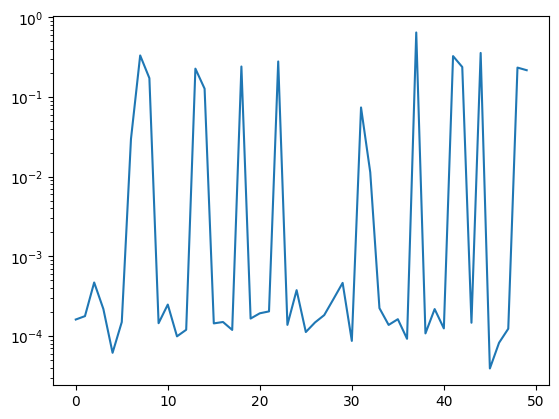

In [539]:
plt.semilogy(err_pos)
for dd in fail_range:
    print(dd[0]*rad2deg, dd[3]*rad2deg)
    print(dd[1],dd[2])
    print('##############')
model.lowerPositionLimit*rad2deg

In [518]:
fail_range

[[array([ 0.78516712, -2.33908157, -1.34415677, -1.17294968, -1.14583165,
          0.50606246]),
  array([-0.02133101, -0.63933441, -0.00215194]),
  array([ 0.71428412, -0.64398097, -0.27401955]),
  array([-2.27470086,  1.85954091,  1.04888483, -1.17283952,  0.75490543,
          0.38699487, -1.41229153]),
  array([[ 0.00000000e+00,  0.00000000e+00,  1.57500000e-01],
         [ 3.00000000e-01, -9.55089412e-11,  1.57500000e-01],
         [ 5.42289243e-27, -3.00000000e-01,  1.57500000e-01],
         [-2.09168280e-10,  2.09206568e-10,  4.57500000e-01],
         [-1.14336246e-05, -1.14268536e-05,  3.60000000e-01],
         [-2.12083018e-01,  2.12181040e-01,  3.60000000e-01],
         [-1.04015698e-01, -1.03956442e-01,  2.17877529e-01],
         [-2.56614101e-01, -2.56467916e-01,  9.42135121e-03],
         [-2.13631399e-01, -2.13511649e-01,  6.81367368e-02],
         [-2.23103167e-02, -1.17595580e-01, -1.42092546e-01],
         [-1.51631153e-01, -3.85857308e-01,  4.59287734e-02],
         

In [519]:
print(new_edge_order[20])
print(list_edges_below)

('lbr_iiwa_joint_2', 'lbr_iiwa_joint_3')
[('lbr_iiwa_joint_1', 'lbr_iiwa_joint_3'), ('y', 'lbr_iiwa_joint_2_tilde'), ('lbr_iiwa_joint_2_tilde', 'lbr_iiwa_joint_4_tilde'), ('lbr_iiwa_joint_3', 'lbr_iiwa_joint_5'), ('lbr_iiwa_joint_4_tilde', 'lbr_iiwa_joint_6_tilde'), ('lbr_iiwa_joint_5', 'lbr_iiwa_joint_7')]
